## Time-Series Forecasting Capstone
0. Helper Functions
1. Example stationary timeseries VAR and VARMAX model
2. two non-stationary timeseries VAR model
3. one non-stationary timeseries VAR model
3. pipeline for all stores

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import seaborn as sns
from datetime import datetime

### 0.Helper Functions

In [2]:
# define helper functions

# remove outliers xx percentile
def remove_outliers(df, column, percentile = 0.99):
    thresh = df[column].quantile(percentile)
    return df[df[column] <= thresh]

# test if stationary
def test_stationary(df, column):
    result = adfuller(df[column], autolag = 'AIC')
    return result[0] < result[4]['5%']

def granger_test(df, X, Y, lags = 1):
    result = grangercausalitytests(df[[Y, X]], lags)
    return result.get(1)[0].get('ssr_ftest')[1]

# seasonal decompose, additive/multiplicative
def decompose(df, column, add_mult = 'additive', freq = 300):
    res = seasonal_decompose(df[column], model = add_mult, period = freq, extrapolate_trend='freq')
    return res

def find_season(df, column, fmax = 300):
    residuals = []
    for i in range(2, fmax):
        result = decompose(df, column, freq = i)
        residuals.append(abs(result.resid.mean()))
    return np.array(residuals).argmin()+2

def return_dummies(df, column, pref = 'day'):
    return pd.get_dummies(df, columns = [column], prefix = pref)

def return_storedata(df, store_id = 1, only_open = 1):
    return df.query(f'Store == {store_id} and Open == {only_open}')

def standardize_series(df, column):
    mean = df[column].mean()
    stdev = df[column].std()
    temp = (df[column] - mean)/stdev
    return mean, stdev, temp

def destandardize_series(series, mean, stdev):
    return stdev*series+mean

def calculate_mpe(true, predicted):
    MPE=np.mean((true-predicted)/true)
    return MPE
    
def calculate_mape(true, predicted):
    MAPE=np.mean(abs((true-predicted)/true))
    return MAPE

def difference_timeseries(series, dropnan = True):
    if dropnan:
        return series.diff().dropna()
    else:
        return series.diff()
    
def dedifference_timeseries(original, diff_series):
    return diff_series.cumsum() + original[-1]

In [3]:
#read the data
data_df = pd.read_csv('data/train.csv', encoding="ISO-8859-1", low_memory=False)

### 1. Stationary timeseries VARMAX model

In [4]:
# choose a store
store_id = 8

In [5]:
# extract the data for "store_id", choose only data on open days
store_df = data_df.query(f'Store == {store_id} and Open == 1')

In [6]:
# sanity check
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
7,8,5,2015-07-31,8492,833,1,1,0,1
1122,8,4,2015-07-30,8420,882,1,1,0,1
2237,8,3,2015-07-29,7029,698,1,1,0,1
3352,8,2,2015-07-28,6717,695,1,1,0,1
4467,8,1,2015-07-27,8739,841,1,1,0,1


In [7]:
store_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1009412,8,1,2013-01-07,7416,802,1,1,0,0
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1014987,8,3,2013-01-02,5419,698,1,0,0,1


In [8]:
# reverse the order...
# data should run from past to present ...
store_df = store_df.iloc[::-1]

In [9]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1014987,8,3,2013-01-02,5419,698,1,0,0,1
1013872,8,4,2013-01-03,4842,662,1,0,0,1
1012757,8,5,2013-01-04,4059,517,1,0,0,1
1011642,8,6,2013-01-05,2337,312,1,0,0,0
1009412,8,1,2013-01-07,7416,802,1,1,0,0


In [10]:
# reset index
store_df = store_df.reset_index(drop=True)

In [11]:
store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,8,3,2013-01-02,5419,698,1,0,0,1
1,8,4,2013-01-03,4842,662,1,0,0,1
2,8,5,2013-01-04,4059,517,1,0,0,1
3,8,6,2013-01-05,2337,312,1,0,0,0
4,8,1,2013-01-07,7416,802,1,1,0,0


In [12]:
# check for missing values
store_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

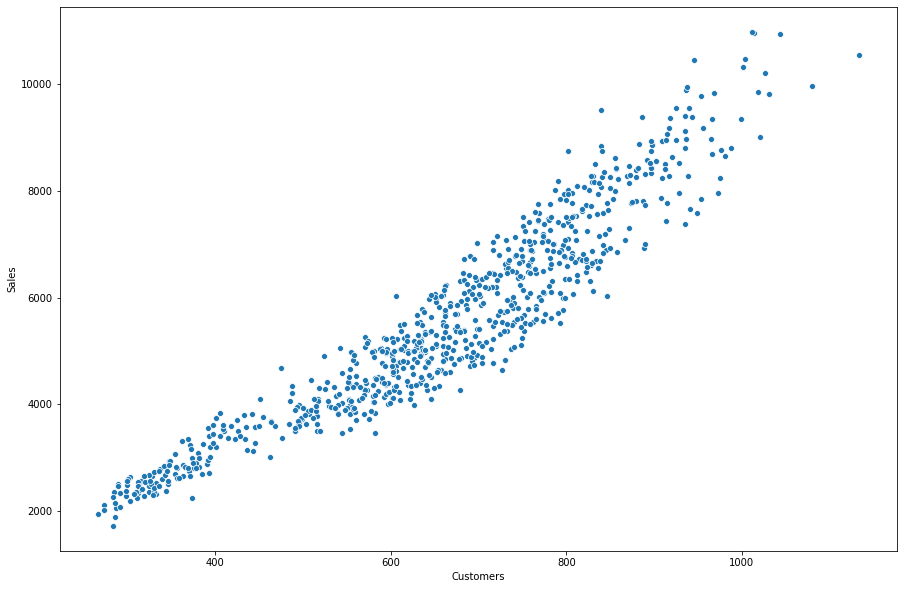

In [13]:
# visual inspection of sales(customers)
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales')

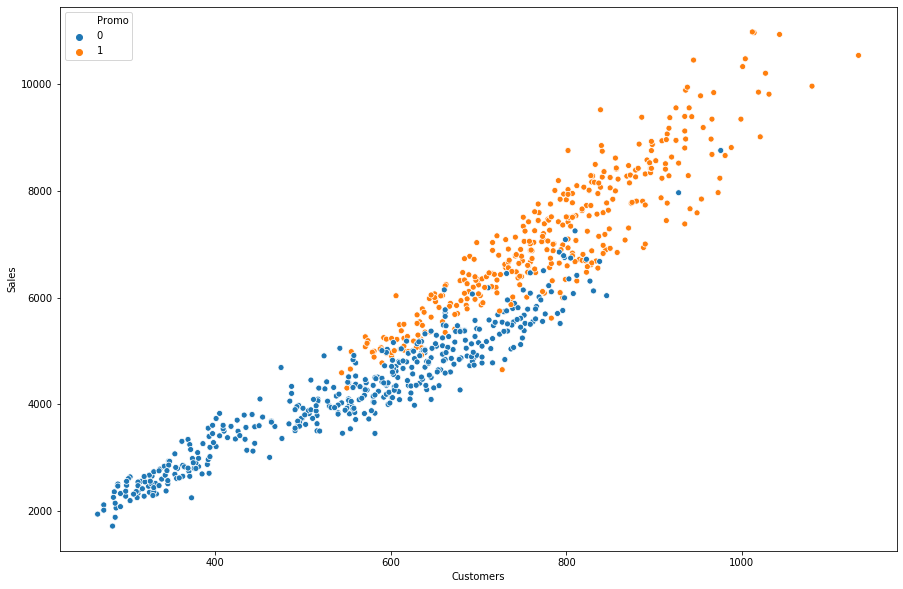

In [14]:
# visual inspection of sales(customers) and add promo influence
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'Promo')

- even visually there is an obvious correlation between sales and customers
- a slightly higher sales happens when promo is available
- also promo seems to attract more customers per day

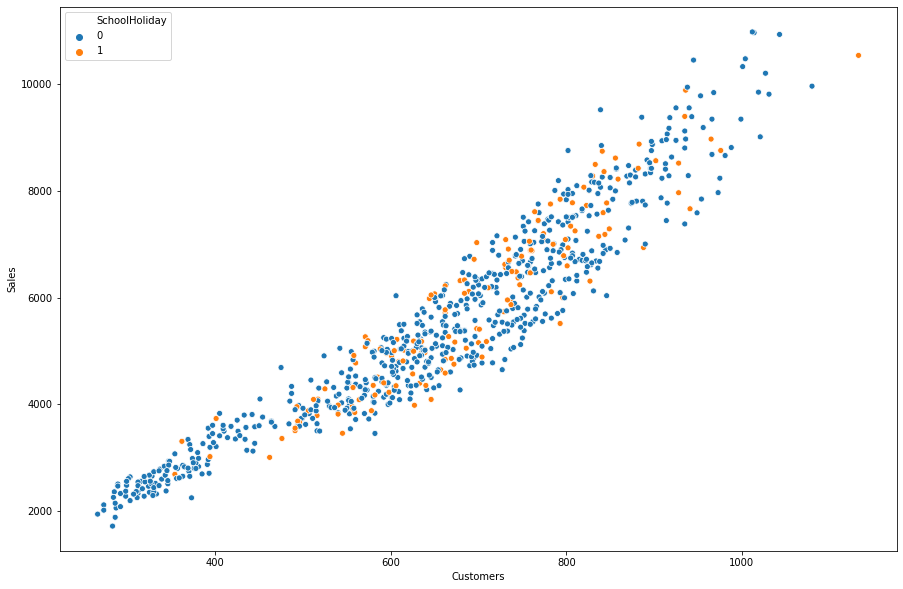

In [15]:
# check schoolholiday influence
plt.figure(figsize = (15,10))
sns.scatterplot(data = store_df, x = 'Customers', y = 'Sales', hue = 'SchoolHoliday')

- overall small effect

In [16]:
# months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

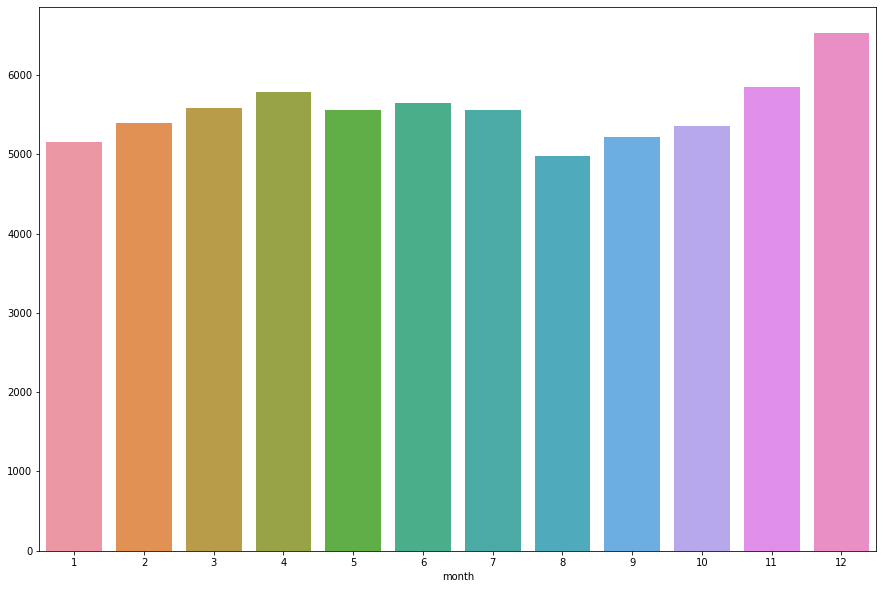

In [17]:
# check some month or weekday effects
result = store_df.groupby(['month']).mean().Sales
plt.figure(figsize = (15,10))
sns.barplot(x = result.index, y = result.values)

- easter seems to have a small effect on sales
- christmas seems to have an even bigger effect on sales

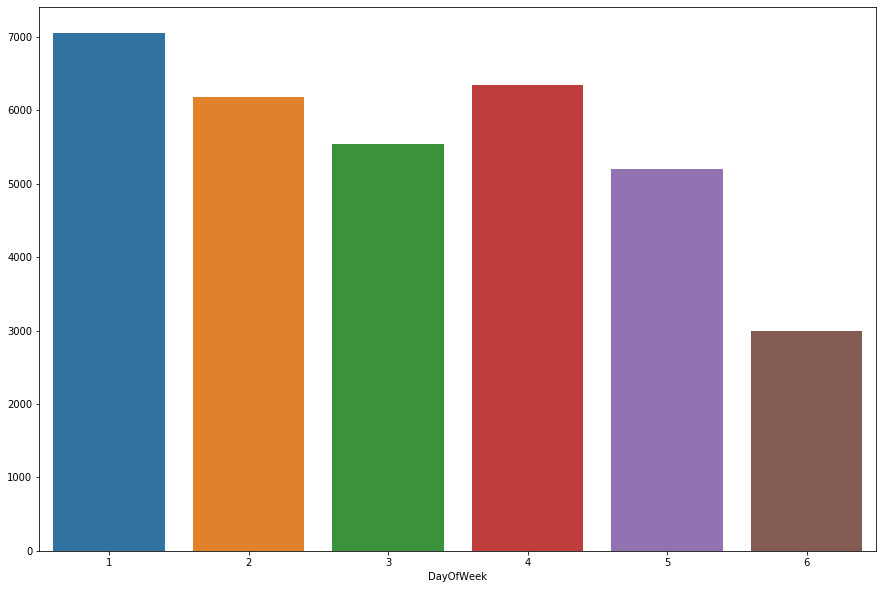

In [18]:
# check for weekdays
result = store_df.groupby(['DayOfWeek']).mean().Sales
plt.figure(figsize = (15,10))
sns.barplot(x = result.index, y = result.values)

- in average, slightly more sales on mondays...even at rossmann

In [19]:
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [20]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,8,2013-01-02,5419,698,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,2013-01-03,4842,662,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,2013-01-04,4059,517,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,2013-01-05,2337,312,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,2013-01-07,7416,802,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# drop store, date, open, stateholiday
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

In [22]:
# remove outliers
store_dummies = remove_outliers(store_dummies, 'Sales')

In [23]:
# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

In [24]:
result = decompose(store_dummies, 'Sales', freq = f_sales)

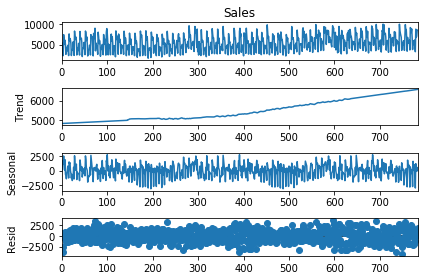

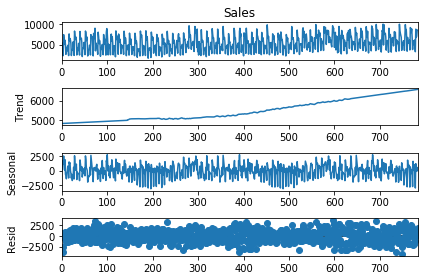

In [25]:
result.plot()

In [26]:
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

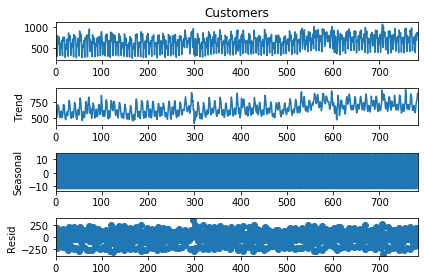

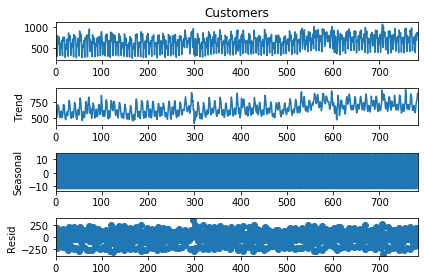

In [27]:
# same for customers
result = decompose(store_dummies, 'Customers', freq = f_customers)
result.plot()

In [28]:
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

In [29]:
# check for stationary
# sales
test_stationary(store_dummies, 'Sales')

True

In [30]:
# customers
test_stationary(store_dummies, 'Customers')

True

In [31]:
# granger
granger_test(store_dummies, 'Customers', 'Sales', lags = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=337.3122, p=0.0000  , df=2
likelihood ratio test: chi2=279.9751, p=0.0000  , df=2
parameter F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3
ssr based chi2 test:   chi2=419.8104, p=0.0000  , df=3
likelihood ratio test: chi2=335.3185, p=0.0000  , df=3
parameter F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3


1.4078965478701753e-35

In [32]:
# granger
granger_test(store_dummies, 'Sales', 'Customers', lags = 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1


1.3671389080044935e-23

- both granger cause each other ...

In [33]:
# split in train and testset
test_size = 40 # 6 weeks á 6 days a week (sundays are off in germany...) are 36, with 40 days seems fair enough
train_df, test_df = store_dummies.iloc[:-1*test_size], store_dummies.iloc[-1*test_size:]

In [34]:
# define endogenouse and exogenous train variables
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

# define endogenouse and exogenous test variables
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

### VAR

In [35]:
# define VAR model
model = VAR(endog_train, exog = exog_train)
result = model.select_order(40)
result.summary()
minimum = result.aic
print(minimum)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6


In [36]:
# fit the model
result_fit = model.fit(maxlags = minimum)

In [37]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = test_size, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


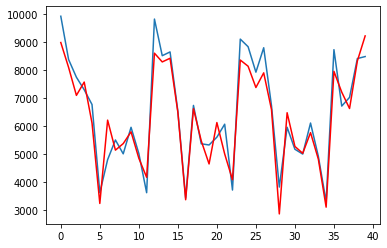

0.02294934204713303
0.07522611606952594


In [38]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

### VARMAX

In [39]:
# define a parametergrid to tune hyperparameters
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [40]:
res = []
for a,b in enumerate(pg):
    # train a varmax model
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    print(f"Trying a: {a} p: {p} and q: {q} and tr: {tr}")
    max_model = VARMAX(endog_train, exog = exog_train, order = (p,q), trend = tr) 
    max_result = max_model.fit(disp = False)
    predicted_df = max_result.forecast(steps = test_size, exog = exog_test)
    MPE=np.mean((endog_test.Sales-predicted_df.Sales)/(endog_test.Sales))
    MAPE=np.mean(abs(endog_test.Sales-predicted_df.Sales)/(endog_test.Sales))
    res.append([a,MPE,MAPE])

Trying a: 0 p: 1 and q: 1 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is availa

Trying a: 1 p: 1 and q: 1 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 2 p: 1 and q: 1 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 3 p: 1 and q: 1 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 4 p: 1 and q: 2 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 5 p: 1 and q: 2 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 6 p: 1 and q: 2 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 7 p: 1 and q: 2 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 8 p: 1 and q: 3 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 9 p: 1 and q: 3 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 10 p: 1 and q: 3 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 11 p: 1 and q: 3 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 12 p: 2 and q: 1 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 13 p: 2 and q: 1 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 14 p: 2 and q: 1 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 15 p: 2 and q: 1 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 16 p: 2 and q: 2 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 17 p: 2 and q: 2 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 18 p: 2 and q: 2 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 19 p: 2 and q: 2 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 20 p: 2 and q: 3 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 21 p: 2 and q: 3 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 22 p: 2 and q: 3 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 23 p: 2 and q: 3 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 24 p: 3 and q: 1 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 25 p: 3 and q: 1 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 26 p: 3 and q: 1 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 27 p: 3 and q: 1 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 28 p: 3 and q: 2 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 29 p: 3 and q: 2 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 30 p: 3 and q: 2 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 31 p: 3 and q: 2 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 32 p: 3 and q: 3 and tr: n


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 33 p: 3 and q: 3 and tr: c


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 34 p: 3 and q: 3 and tr: t


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,

Trying a: 35 p: 3 and q: 3 and tr: ct


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [41]:
mape = [abs(res[i][2]) for i in range(len(res))]

In [42]:
pg[np.array(mape).argmin()]

{'p': 3, 'q': 3, 'tr': 'n'}

In [43]:
# train a varmax model
max_model = VARMAX(endog_train, exog = exog_train, order = (3,3), trend = 'n') 
max_result = max_model.fit(disp = False)

print(max_result.summary())
print(max_result.params)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  736
Model:                        VARMAX(3,3)   Log Likelihood               -9961.510
Date:                    Mon, 04 Jan 2021   AIC                          20073.020
Time:                            06:30:35   BIC                          20418.112
Sample:                                 0   HQIC                         20206.109
                                    - 736                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              251.94, 192.87   Jarque-Bera (JB):          3.90, 65.05
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.14, 0.00
Heteroskedasticity (H):         1.37, 1.79   Skew:                       0.18, 0.27
Prob(H) (two-sided):            0.01, 0.00   Kurtosis:                   2.97, 4.35


In [44]:
# forecast
predicted_df = max_result.forecast(steps = 40, exog = exog_test)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


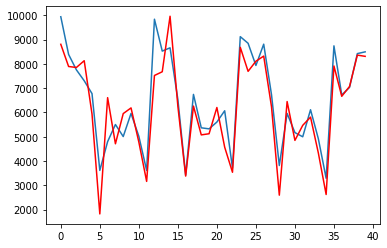

0.049007902765073656
0.10857945647396246


In [45]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]


# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

VAR slightly better performed than VARMAX

In [46]:
result = granger_test(store_dummies, 'Customers', 'Sales', lags = 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=172.4309, p=0.0000  , df=1
likelihood ratio test: chi2=155.6905, p=0.0000  , df=1
parameter F test:         F=171.7635, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=337.3122, p=0.0000  , df=2
likelihood ratio test: chi2=279.9751, p=0.0000  , df=2
parameter F test:         F=167.5666, p=0.0000  , df_denom=769, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3
ssr based chi2 test:   chi2=419.8104, p=0.0000  , df=3
likelihood ratio test: chi2=335.3185, p=0.0000  , df=3
parameter F test:         F=138.6696, p=0.0000  , df_denom=766, df_num=3


In [47]:
result = grangercausalitytests(store_dummies[['Customers', 'Sales']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1
ssr based chi2 test:   chi2=107.4998, p=0.0000  , df=1
likelihood ratio test: chi2=100.6690, p=0.0000  , df=1
parameter F test:         F=107.0836, p=0.0000  , df_denom=772, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=138.6125, p=0.0000  , df_denom=769, df_num=2
ssr based chi2 test:   chi2=279.0276, p=0.0000  , df=2
likelihood ratio test: chi2=238.2781, p=0.0000  , df=2
parameter F test:         F=138.6125, p=0.0000  , df_denom=769, df_num=2


### 2. both non-stationary timeseries VAR model

In [48]:
# select store
store_df = return_storedata(data_df, 30)

In [49]:
# reverse order
store_df = store_df.iloc[::-1]
# remove outliers in sales, 99. percentile
store_df = remove_outliers(store_df, 'Sales')
# reset index
store_df = store_df.reset_index(drop = True)

In [50]:
# extract months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

In [51]:
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [52]:
#check stationary
#sales
print(f"Sales series is stationary? {test_stationary(store_dummies, 'Sales')}")
print(f"Customer series is stationary? {test_stationary(store_dummies, 'Customers')}")

Sales series is stationary? False
Customer series is stationary? False


In [53]:
store_dummies.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,day_1,day_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,30,2013-01-02,5683,943,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,2013-01-03,6219,987,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,2013-01-04,5035,803,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,2013-01-05,5643,898,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,2013-01-07,9174,1187,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

In [55]:
# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

In [56]:
result = decompose(store_dummies, 'Sales', freq = f_sales)
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

In [57]:
result = decompose(store_dummies, 'Customers', freq = f_customers)
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

In [58]:
# standardization casuing trouble... so skipping it
#sales_mean, sales_std, sales_changed = standardize_series(store_dummies, 'Sales')
#cutomers_mean, cutomers_std, customers_changed = standardize_series(store_dummies, 'Customers')

In [59]:
#store_dummies['Sales_st'] = sales_changed
#store_dummies['Customers_st'] = customers_changed

In [60]:
#train-test-split
lag = 40
train_df, test_df = store_dummies.iloc[:-1*lag], store_dummies.iloc[-1*lag:]

In [61]:
#sep in endog and exog
# define endogenouse and exogenous variables
#endog = train_df[['Sales','Customers']].astype('float32')
#exog = train_df[['Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')
#exog_binary = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']].astype('float32')

In [62]:
# define endogenouse and exogenous test variables
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [63]:
endog_diff = endog_train.diff().dropna().reset_index(drop = True)
#exog_diff = exog_train.diff().dropna().reset_index(drop = True)
exog_diff = exog_train.iloc[1:].reset_index(drop = True)

In [64]:
# define endogenouse and exogenous test variables
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [65]:
# define VAR model
model = VAR(endog_diff, exog = exog_diff)
result = model.select_order(f_sales)
result.summary()
minimum = result.aic
minimum

26

In [66]:
# fit the model
result_fit = model.fit(maxlags = minimum)

In [67]:
#predicted_df = pd.DataFrame(result_fit.forecast(y = endog_train[-40:].values, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [68]:
predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]

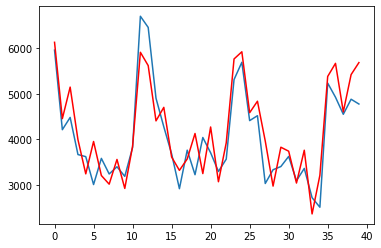

-0.04374199701691791
0.10868261034219948


In [69]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

### 3. One non-stationary time series

In [70]:
# select store
store_df = return_storedata(data_df, 6)
# reverse order
store_df = store_df.iloc[::-1]
# remove outliers in sales, 99. percentile
store_df = remove_outliers(store_df, 'Sales')
# reset index
store_df = store_df.reset_index(drop = True)
# extract months
store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)
# create dummies for weekdays and months
store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
store_dummies = return_dummies(store_dummies, 'month', pref = 'month')

In [71]:
#check stationary
#sales
print(f"Sales series is stationary? {test_stationary(store_dummies, 'Sales')}")
print(f"Customer series is stationary? {test_stationary(store_dummies, 'Customers')}")

Sales series is stationary? True
Customer series is stationary? False


In [72]:
#drop not useful features
store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

# decompose the timeseries
# find the frequency with the lowest error
f_sales = find_season(store_dummies, 'Sales')
f_customers = find_season(store_dummies, 'Customers')

result = decompose(store_dummies, 'Sales', freq = f_sales)
# save the trend and seasonality as features
store_dummies['Sales_trend'] = result.trend
store_dummies['Sales_season'] = result.seasonal

result = decompose(store_dummies, 'Customers', freq = f_customers)
store_dummies['Customers_trend'] = result.trend
store_dummies['Customers_season'] = result.seasonal

#train-test-split
lag = 40
train_df, test_df = store_dummies.iloc[:-1*lag], store_dummies.iloc[-1*lag:]

In [73]:
# define endogenouse and exogenous train variables
endog_train = train_df[['Sales','Customers']].astype('float32')
exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

endog_diff = endog_train.diff().dropna().reset_index(drop = True)
exog_diff = exog_train.iloc[1:].reset_index(drop = True)

# define endogenouse and exogenous test variables
endog_test = test_df[['Sales','Customers']].astype('float32')
exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

In [74]:
# define VAR model
model = VAR(endog_diff, exog = exog_diff)
result = model.select_order(f_sales)
result.summary()
minimum = result.aic
minimum

28

In [75]:
# fit the model
result_fit = model.fit(maxlags = minimum)

In [76]:
predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = 40, exog_future = exog_test.values), columns = ['Sales', 'Customers'])

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [77]:
# de-difference
predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]

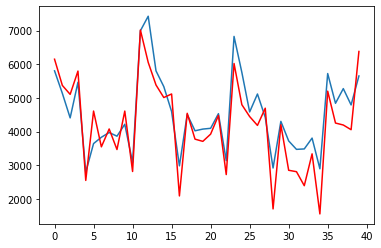

0.07802309005245002
0.12924992515397496


In [78]:
import matplotlib.pyplot as plt

actual=endog_test[["Sales"]]

actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=predicted_df[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)

# plot
plt.plot(actual)
plt.plot(predicted, color='red')
plt.show()

MPE=calculate_mpe(pred.ActualSales,pred.Sales)
print(MPE)

MAPE=calculate_mape(pred.ActualSales,pred.Sales)
print(MAPE)

### 4. Pipeline

In [79]:
def rossmann_prediction(data_df, store_id, days = 40, lags_max = 40, plotting = False, max_f = 190):

    # select store
    store_df = return_storedata(data_df, store_id)
    
    # reverse order
    store_df = store_df.iloc[::-1]

    # remove outliers in sales, 99. percentile
    store_df = remove_outliers(store_df, 'Sales')
    
    # reset index
    store_df = store_df.reset_index(drop = True)

    # extract months
    store_df['month'] = store_df.Date.apply(lambda str_: datetime.strptime(str_, '%Y-%m-%d').month)

    # create dummies for weekdays and months
    store_dummies = return_dummies(store_df, 'DayOfWeek', pref = 'day')
    store_dummies = return_dummies(store_dummies, 'month', pref = 'month')
    
    #check stationary
    sales_stationary = test_stationary(store_dummies, 'Sales')
    customers_stationary = test_stationary(store_dummies, 'Customers')
    stationary = sales_stationary and customers_stationary
    
    #drop not useful features
    store_dummies = store_dummies.drop(['Store', 'Date', 'Open','StateHoliday'], axis = 1)

    # decompose the timeseries
    # find the frequency with the lowest error sales
    f_sales = find_season(store_dummies, 'Sales', fmax = max_f)
    f_customers = find_season(store_dummies, 'Customers', fmax = max_f)
    result = decompose(store_dummies, 'Sales', freq = f_sales)
    # save the trend and seasonality as features
    store_dummies['Sales_trend'] = result.trend
    store_dummies['Sales_season'] = result.seasonal

    # find the frequency with the lowest error customers
    result = decompose(store_dummies, 'Customers', freq = f_customers)
    # save the trend and seasonality as features
    store_dummies['Customers_trend'] = result.trend
    store_dummies['Customers_season'] = result.seasonal

    #train-test-split
    train_df, test_df = store_dummies.iloc[:-1*days], store_dummies.iloc[-1*days:]
    
    # define endogenouse and exogenous train variables
    endog_train = train_df[['Sales','Customers']].astype('float32')
    exog_train = train_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')

    # difference the timeseries if sales or customers timeseries isn't stationary
    if not stationary:
        endog_train = endog_train.diff().dropna().reset_index(drop = True)
        exog_train = exog_train.iloc[1:].reset_index(drop = True)
        
    # define endogenouse and exogenous test variables
    endog_test = test_df[['Sales','Customers']].astype('float32')
    exog_test = test_df[['Promo', 'SchoolHoliday' ,'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Customers_season', 'Sales_season', 'Customers_trend', 'Sales_trend']].astype('float32')
    
    # define VAR model
    model = VAR(endog_train, exog = exog_train)
    result = model.select_order(lags_max)
    result.summary()
    minimum = result.aic
    
    # fit the model
    result_fit = model.fit(maxlags = minimum)
    
    # forecast the model
    predicted_df = pd.DataFrame(result_fit.forecast(y = result_fit.y, steps = days, exog_future = exog_test.values), columns = ['Sales', 'Customers'])
    
    # de-difference if necessary
    if not stationary:
        predicted_df['Sales'] = predicted_df['Sales'].cumsum()+train_df['Sales'].values[-1]
    
    # benchmark
    actual=endog_test[["Sales"]]
    actual.columns=['ActualSales']
    actual=actual.reset_index(drop=True)
    predicted=predicted_df[['Sales']]
    predicted=predicted.reset_index(drop=True)
    pred=pd.merge(actual, predicted, right_index=True, left_index=True)

    # plot
    fig = plt.figure(figsize = (10,8))
    plt.title(f"{days} business days sales forecasting for Rossmann store ID: {store_id}", fontsize = 16)
    plt.xlabel("days", fontsize = 14)
    plt.ylabel("sales in euro", fontsize = 14)
    plt.plot(actual, label = "Groundtruth")
    plt.plot(predicted, color='red', label = "Forecast")
    plt.legend()
    plt.savefig(f"./output/store_{store_id}.png")
    if plotting:
        plt.show()
    plt.close(fig)
    
    pred.to_csv(f"./output/store_{store_id}.csv")
    MPE=calculate_mpe(pred.ActualSales,pred.Sales)
    #print(MPE)

    MAPE=calculate_mape(pred.ActualSales,pred.Sales)
    #print(MAPE)
    return [MPE,MAPE,stationary,minimum]

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


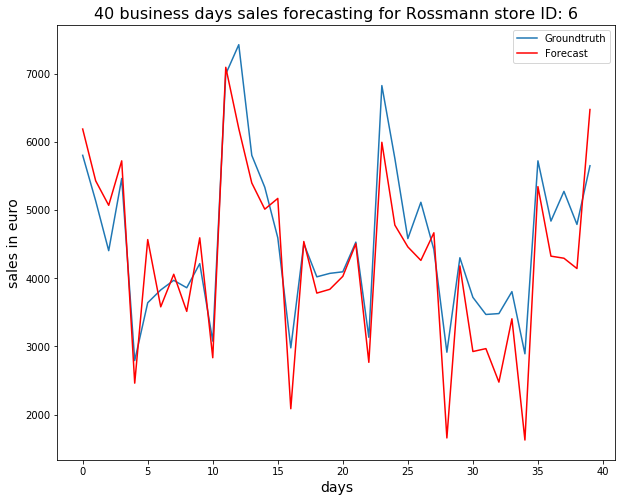

[0.06983059972266854, 0.12169644471805066, False, 31]

In [80]:
rossmann_prediction(data_df, 6, days = 40, plotting = True)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


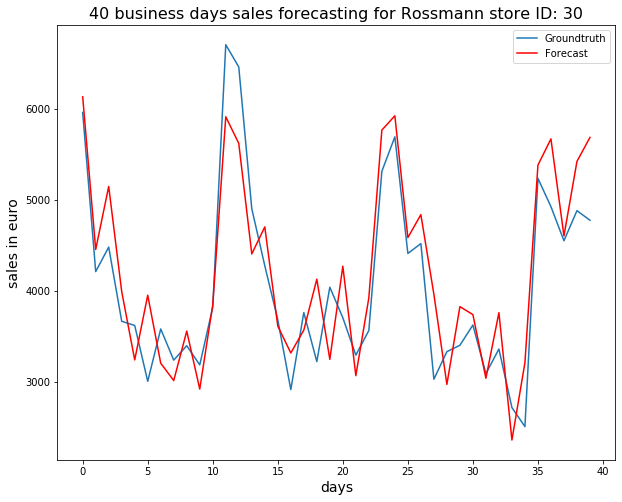

[-0.04374199701691791, 0.10868261034219948, False, 26]

In [81]:
rossmann_prediction(data_df, 30, days = 40, plotting = True)

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


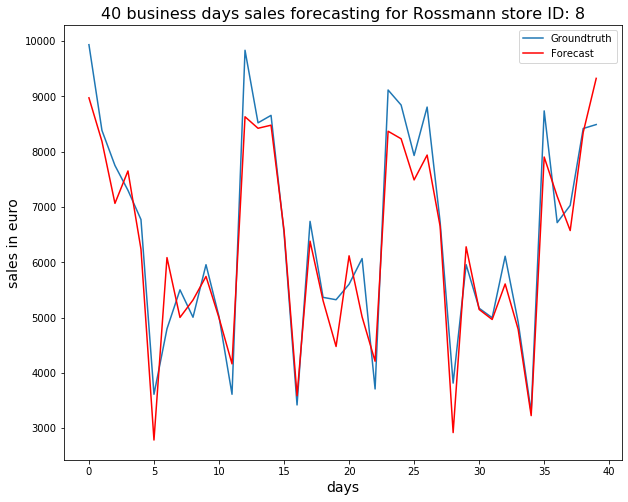

In [82]:
results = rossmann_prediction(data_df, 8, days = 40, plotting = True)

In [83]:
MPEs = []
MAPEs = []
Stationaries = []
AICs = []
for i in range(1,1116):
    results = rossmann_prediction(data_df, i, days = 40)
    MPEs.append(results[0])
    MAPEs.append(results[1])
    Stationaries.append(results[2])
    AICs.append(results[3])
    print(f"Store ID: {i}\tStationary: {results[2]}\tMPE: {results[0]:.4f}\tMAPE: {results[1]:.4f}\tAIC: {results[3]}")

C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1	Stationary: True	MPE: 0.0249	MAPE: 0.0868	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 2	Stationary: True	MPE: -0.0113	MAPE: 0.1012	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 3	Stationary: True	MPE: -0.0303	MAPE: 0.0466	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 4	Stationary: True	MPE: 0.0557	MAPE: 0.0811	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 5	Stationary: True	MPE: -0.0063	MAPE: 0.0628	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 6	Stationary: False	MPE: 0.0698	MAPE: 0.1217	AIC: 31


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 7	Stationary: True	MPE: -0.0232	MAPE: 0.0712	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 8	Stationary: True	MPE: 0.0255	MAPE: 0.0774	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 9	Stationary: True	MPE: -0.0096	MAPE: 0.0674	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 10	Stationary: True	MPE: -0.0153	MAPE: 0.0854	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 11	Stationary: True	MPE: 0.0302	MAPE: 0.1055	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 12	Stationary: True	MPE: 0.0484	MAPE: 0.0845	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 13	Stationary: True	MPE: -0.0365	MAPE: 0.1169	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 14	Stationary: True	MPE: 0.0228	MAPE: 0.0600	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 15	Stationary: True	MPE: 0.0176	MAPE: 0.0931	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 16	Stationary: True	MPE: -0.0270	MAPE: 0.0772	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 17	Stationary: True	MPE: -0.0399	MAPE: 0.0975	AIC: 22


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 18	Stationary: True	MPE: -0.0165	MAPE: 0.0826	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 19	Stationary: True	MPE: -0.0058	MAPE: 0.0756	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 20	Stationary: True	MPE: -0.0240	MAPE: 0.0768	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 21	Stationary: True	MPE: 0.0023	MAPE: 0.1057	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 22	Stationary: True	MPE: 0.0342	MAPE: 0.0894	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 23	Stationary: True	MPE: -0.0101	MAPE: 0.1093	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 24	Stationary: True	MPE: 0.0159	MAPE: 0.0821	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 25	Stationary: True	MPE: -0.0894	MAPE: 0.1141	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 26	Stationary: True	MPE: -0.0399	MAPE: 0.0935	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 27	Stationary: True	MPE: 0.0213	MAPE: 0.0771	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 28	Stationary: True	MPE: -0.0255	MAPE: 0.0760	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 29	Stationary: True	MPE: -0.0058	MAPE: 0.0972	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 30	Stationary: False	MPE: -0.0437	MAPE: 0.1087	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 31	Stationary: True	MPE: 0.0076	MAPE: 0.0647	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 32	Stationary: True	MPE: -0.0890	MAPE: 0.1180	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 33	Stationary: True	MPE: 0.0123	MAPE: 0.0809	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 34	Stationary: True	MPE: -0.0056	MAPE: 0.0810	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 35	Stationary: True	MPE: 0.0239	MAPE: 0.0966	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 36	Stationary: True	MPE: -0.0105	MAPE: 0.0624	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 37	Stationary: True	MPE: -0.0001	MAPE: 0.0747	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 38	Stationary: True	MPE: -0.0117	MAPE: 0.1120	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 39	Stationary: True	MPE: -0.0127	MAPE: 0.1003	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 40	Stationary: True	MPE: -0.0568	MAPE: 0.0952	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 41	Stationary: True	MPE: 0.0363	MAPE: 0.0890	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 42	Stationary: True	MPE: 0.0250	MAPE: 0.0817	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 43	Stationary: True	MPE: -0.0010	MAPE: 0.0844	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 44	Stationary: True	MPE: 0.0201	MAPE: 0.1019	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 45	Stationary: True	MPE: -0.0344	MAPE: 0.0944	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 46	Stationary: True	MPE: 0.0079	MAPE: 0.0961	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 47	Stationary: True	MPE: 0.0085	MAPE: 0.0698	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 48	Stationary: False	MPE: 0.1178	MAPE: 0.1295	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 49	Stationary: True	MPE: 0.0129	MAPE: 0.0590	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 50	Stationary: True	MPE: 0.0271	MAPE: 0.1028	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 51	Stationary: True	MPE: 0.0062	MAPE: 0.0778	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 52	Stationary: True	MPE: 0.0301	MAPE: 0.1087	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 53	Stationary: True	MPE: -0.0209	MAPE: 0.0749	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 54	Stationary: True	MPE: 0.0147	MAPE: 0.0751	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 55	Stationary: False	MPE: 0.0099	MAPE: 0.0524	AIC: 38


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 56	Stationary: True	MPE: 0.0066	MAPE: 0.0695	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 57	Stationary: True	MPE: -0.0237	MAPE: 0.0794	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 58	Stationary: True	MPE: 0.0132	MAPE: 0.0773	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 59	Stationary: True	MPE: 0.0052	MAPE: 0.0812	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 60	Stationary: True	MPE: -0.0017	MAPE: 0.0892	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 61	Stationary: True	MPE: 0.0151	MAPE: 0.1017	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 62	Stationary: True	MPE: -0.0069	MAPE: 0.0592	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 63	Stationary: True	MPE: -0.0158	MAPE: 0.0832	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 64	Stationary: True	MPE: 0.0011	MAPE: 0.0747	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 65	Stationary: True	MPE: -0.0241	MAPE: 0.0862	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 66	Stationary: True	MPE: -0.0068	MAPE: 0.0859	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 67	Stationary: True	MPE: 0.0323	MAPE: 0.0861	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 68	Stationary: True	MPE: 0.0222	MAPE: 0.1039	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 69	Stationary: True	MPE: 0.0234	MAPE: 0.0808	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 70	Stationary: True	MPE: 0.0177	MAPE: 0.1028	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 71	Stationary: True	MPE: -0.0643	MAPE: 0.0870	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 72	Stationary: True	MPE: 0.0339	MAPE: 0.1206	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 73	Stationary: True	MPE: -0.0079	MAPE: 0.0617	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 74	Stationary: True	MPE: 0.0107	MAPE: 0.0858	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 75	Stationary: True	MPE: -0.0080	MAPE: 0.0517	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 76	Stationary: True	MPE: -0.0381	MAPE: 0.1030	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 77	Stationary: True	MPE: 0.0023	MAPE: 0.0747	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 78	Stationary: True	MPE: -0.0296	MAPE: 0.1108	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 79	Stationary: True	MPE: 0.0042	MAPE: 0.0850	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 80	Stationary: True	MPE: 0.0337	MAPE: 0.0642	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 81	Stationary: True	MPE: -0.0323	MAPE: 0.0805	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 82	Stationary: True	MPE: 0.0064	MAPE: 0.0773	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 83	Stationary: True	MPE: -0.0334	MAPE: 0.0906	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 84	Stationary: True	MPE: 0.0182	MAPE: 0.0662	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 85	Stationary: True	MPE: -0.0076	MAPE: 0.0807	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 86	Stationary: True	MPE: 0.0361	MAPE: 0.1018	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 87	Stationary: True	MPE: -0.0088	MAPE: 0.0903	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 88	Stationary: True	MPE: 0.0386	MAPE: 0.0975	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 89	Stationary: True	MPE: -0.0230	MAPE: 0.0688	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 90	Stationary: True	MPE: -0.0278	MAPE: 0.1000	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 91	Stationary: False	MPE: 0.1368	MAPE: 0.1628	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 92	Stationary: True	MPE: -0.0207	MAPE: 0.0910	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 93	Stationary: True	MPE: -0.0251	MAPE: 0.0864	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 94	Stationary: True	MPE: -0.0130	MAPE: 0.0631	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 95	Stationary: True	MPE: -0.0143	MAPE: 0.0740	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 96	Stationary: True	MPE: 0.0106	MAPE: 0.0900	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 97	Stationary: True	MPE: 0.0305	MAPE: 0.0728	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 98	Stationary: True	MPE: 0.0360	MAPE: 0.0705	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 99	Stationary: True	MPE: 0.0078	MAPE: 0.0860	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 100	Stationary: True	MPE: -0.0562	MAPE: 0.0942	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 101	Stationary: True	MPE: 0.0060	MAPE: 0.1040	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 102	Stationary: True	MPE: -0.0289	MAPE: 0.1090	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 103	Stationary: True	MPE: -0.0000	MAPE: 0.0681	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 104	Stationary: True	MPE: -0.0120	MAPE: 0.0586	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 105	Stationary: False	MPE: 0.0518	MAPE: 0.1091	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 106	Stationary: True	MPE: -0.0213	MAPE: 0.0848	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 107	Stationary: True	MPE: 0.0168	MAPE: 0.0694	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 108	Stationary: True	MPE: 0.0014	MAPE: 0.0647	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 109	Stationary: True	MPE: -0.0116	MAPE: 0.0995	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 110	Stationary: True	MPE: -0.0224	MAPE: 0.1035	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 111	Stationary: True	MPE: 0.0098	MAPE: 0.0789	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 112	Stationary: True	MPE: 0.0150	MAPE: 0.0884	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 113	Stationary: False	MPE: -0.0437	MAPE: 0.0795	AIC: 27


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 114	Stationary: True	MPE: -0.0284	MAPE: 0.0889	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 115	Stationary: True	MPE: -0.0357	MAPE: 0.0837	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 116	Stationary: True	MPE: 0.0108	MAPE: 0.0578	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 117	Stationary: True	MPE: -0.0548	MAPE: 0.1068	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 118	Stationary: True	MPE: -0.0107	MAPE: 0.1262	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 119	Stationary: True	MPE: -0.0084	MAPE: 0.0850	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 120	Stationary: True	MPE: 0.0138	MAPE: 0.0764	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 121	Stationary: True	MPE: -0.0691	MAPE: 0.0887	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 122	Stationary: False	MPE: -0.1191	MAPE: 0.1226	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 123	Stationary: True	MPE: -0.0831	MAPE: 0.1194	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 124	Stationary: True	MPE: -0.0832	MAPE: 0.1308	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 125	Stationary: True	MPE: -0.0215	MAPE: 0.1171	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 126	Stationary: True	MPE: 0.0344	MAPE: 0.1369	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 127	Stationary: True	MPE: -0.0278	MAPE: 0.1067	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 128	Stationary: False	MPE: -0.0677	MAPE: 0.1152	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 129	Stationary: True	MPE: -0.0007	MAPE: 0.0729	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 130	Stationary: True	MPE: 0.0178	MAPE: 0.0716	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 131	Stationary: False	MPE: -0.1948	MAPE: 0.2049	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 132	Stationary: False	MPE: -0.0164	MAPE: 0.0688	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 133	Stationary: True	MPE: -0.0049	MAPE: 0.0720	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 134	Stationary: True	MPE: -0.0233	MAPE: 0.0639	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 135	Stationary: True	MPE: -0.0277	MAPE: 0.1128	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 136	Stationary: False	MPE: -0.0857	MAPE: 0.1240	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 137	Stationary: True	MPE: -0.0134	MAPE: 0.0799	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 138	Stationary: True	MPE: -0.0142	MAPE: 0.0651	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 139	Stationary: True	MPE: -0.0660	MAPE: 0.1203	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 140	Stationary: True	MPE: -0.0061	MAPE: 0.0707	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 141	Stationary: True	MPE: 0.0178	MAPE: 0.0707	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 142	Stationary: True	MPE: -0.0276	MAPE: 0.0648	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 143	Stationary: True	MPE: -0.0425	MAPE: 0.1062	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 144	Stationary: True	MPE: -0.0016	MAPE: 0.0425	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 145	Stationary: False	MPE: -0.0968	MAPE: 0.1223	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 146	Stationary: True	MPE: 0.0111	MAPE: 0.0833	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 147	Stationary: True	MPE: 0.0059	MAPE: 0.0735	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 148	Stationary: True	MPE: 0.0014	MAPE: 0.0559	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 149	Stationary: True	MPE: -0.0902	MAPE: 0.1423	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 150	Stationary: True	MPE: 0.0058	MAPE: 0.1052	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 151	Stationary: True	MPE: -0.0191	MAPE: 0.0584	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 152	Stationary: True	MPE: -0.0600	MAPE: 0.0894	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 153	Stationary: True	MPE: -0.0864	MAPE: 0.1118	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 154	Stationary: True	MPE: -0.0157	MAPE: 0.0612	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 155	Stationary: True	MPE: -0.0174	MAPE: 0.0967	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 156	Stationary: True	MPE: 0.0266	MAPE: 0.0847	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 157	Stationary: True	MPE: 0.0383	MAPE: 0.0732	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 158	Stationary: True	MPE: 0.0185	MAPE: 0.0707	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 159	Stationary: True	MPE: -0.0137	MAPE: 0.0647	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 160	Stationary: True	MPE: 0.0183	MAPE: 0.0740	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 161	Stationary: True	MPE: 0.0161	MAPE: 0.0663	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 162	Stationary: True	MPE: 0.0100	MAPE: 0.0888	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 163	Stationary: False	MPE: 0.0780	MAPE: 0.1052	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 164	Stationary: True	MPE: -0.0225	MAPE: 0.0892	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 165	Stationary: True	MPE: -0.0132	MAPE: 0.0727	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 166	Stationary: True	MPE: -0.0544	MAPE: 0.1329	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 167	Stationary: True	MPE: -0.0216	MAPE: 0.0674	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 168	Stationary: True	MPE: 0.0219	MAPE: 0.0833	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 169	Stationary: False	MPE: 0.0666	MAPE: 0.1211	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 170	Stationary: True	MPE: -0.0014	MAPE: 0.0948	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 171	Stationary: True	MPE: 0.0233	MAPE: 0.0600	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 172	Stationary: True	MPE: -0.0013	MAPE: 0.0552	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 173	Stationary: True	MPE: 0.0021	MAPE: 0.0819	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 174	Stationary: True	MPE: -0.0498	MAPE: 0.1062	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 175	Stationary: True	MPE: 0.0334	MAPE: 0.0609	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 176	Stationary: True	MPE: -0.0095	MAPE: 0.0935	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 177	Stationary: True	MPE: -0.0111	MAPE: 0.1109	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 178	Stationary: True	MPE: 0.0234	MAPE: 0.0634	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 179	Stationary: True	MPE: 0.0040	MAPE: 0.0832	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 180	Stationary: True	MPE: 0.0218	MAPE: 0.0810	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 181	Stationary: True	MPE: -0.0275	MAPE: 0.0934	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 182	Stationary: True	MPE: -0.0004	MAPE: 0.0563	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 183	Stationary: True	MPE: 0.0367	MAPE: 0.1431	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 184	Stationary: True	MPE: -0.0322	MAPE: 0.0726	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 185	Stationary: True	MPE: 0.0343	MAPE: 0.0956	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 186	Stationary: True	MPE: -0.0854	MAPE: 0.1061	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 187	Stationary: True	MPE: 0.0247	MAPE: 0.1054	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 188	Stationary: True	MPE: 0.0171	MAPE: 0.1080	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 189	Stationary: True	MPE: 0.0033	MAPE: 0.0667	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 190	Stationary: True	MPE: 0.0126	MAPE: 0.0635	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 191	Stationary: True	MPE: -0.0096	MAPE: 0.0758	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 192	Stationary: False	MPE: -0.0218	MAPE: 0.0744	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 193	Stationary: True	MPE: -0.0200	MAPE: 0.0901	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 194	Stationary: True	MPE: -0.0002	MAPE: 0.0761	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 195	Stationary: True	MPE: -0.0225	MAPE: 0.0752	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 196	Stationary: True	MPE: 0.0114	MAPE: 0.0756	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 197	Stationary: True	MPE: 0.0017	MAPE: 0.0620	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 198	Stationary: True	MPE: -0.0345	MAPE: 0.1612	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 199	Stationary: True	MPE: 0.0093	MAPE: 0.0869	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 200	Stationary: True	MPE: -0.1086	MAPE: 0.1455	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 201	Stationary: True	MPE: -0.0775	MAPE: 0.1014	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 202	Stationary: True	MPE: -0.0364	MAPE: 0.0731	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 203	Stationary: True	MPE: -0.0168	MAPE: 0.0630	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 204	Stationary: True	MPE: -0.0155	MAPE: 0.0768	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 205	Stationary: True	MPE: 0.0018	MAPE: 0.0902	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 206	Stationary: True	MPE: -0.0120	MAPE: 0.0881	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 207	Stationary: True	MPE: 0.0302	MAPE: 0.0822	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 208	Stationary: True	MPE: 0.0154	MAPE: 0.1012	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 209	Stationary: True	MPE: -0.0143	MAPE: 0.1118	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 210	Stationary: True	MPE: -0.0421	MAPE: 0.0999	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 211	Stationary: True	MPE: 0.0031	MAPE: 0.0785	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 212	Stationary: True	MPE: -0.0183	MAPE: 0.0694	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 213	Stationary: True	MPE: -0.0320	MAPE: 0.1038	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 214	Stationary: True	MPE: 0.0088	MAPE: 0.0765	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 215	Stationary: True	MPE: -0.0239	MAPE: 0.1065	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 216	Stationary: True	MPE: -0.0238	MAPE: 0.0761	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 217	Stationary: True	MPE: -0.0348	MAPE: 0.0922	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 218	Stationary: True	MPE: 0.0052	MAPE: 0.0785	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 219	Stationary: True	MPE: -0.0392	MAPE: 0.0852	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 220	Stationary: True	MPE: -0.0136	MAPE: 0.1031	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 221	Stationary: True	MPE: 0.0069	MAPE: 0.0751	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 222	Stationary: True	MPE: 0.0044	MAPE: 0.0818	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 223	Stationary: True	MPE: 0.0190	MAPE: 0.0856	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 224	Stationary: True	MPE: 0.0527	MAPE: 0.0731	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 225	Stationary: True	MPE: -0.0238	MAPE: 0.0946	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 226	Stationary: True	MPE: -0.0234	MAPE: 0.0778	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 227	Stationary: True	MPE: -0.0212	MAPE: 0.0555	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 228	Stationary: True	MPE: -0.0642	MAPE: 0.0974	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 229	Stationary: True	MPE: 0.0133	MAPE: 0.0705	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 230	Stationary: True	MPE: 0.0011	MAPE: 0.0997	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 231	Stationary: True	MPE: 0.0117	MAPE: 0.0850	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 232	Stationary: True	MPE: 0.0254	MAPE: 0.0937	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 233	Stationary: True	MPE: 0.0107	MAPE: 0.0555	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 234	Stationary: True	MPE: 0.0035	MAPE: 0.1039	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 235	Stationary: True	MPE: -0.0291	MAPE: 0.1043	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 236	Stationary: True	MPE: -0.0067	MAPE: 0.0587	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 237	Stationary: True	MPE: -0.0266	MAPE: 0.0810	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 238	Stationary: True	MPE: -0.0472	MAPE: 0.1165	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 239	Stationary: True	MPE: -0.0492	MAPE: 0.0947	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 240	Stationary: True	MPE: -0.0111	MAPE: 0.0880	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 241	Stationary: True	MPE: 0.0410	MAPE: 0.0782	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 242	Stationary: True	MPE: -0.0118	MAPE: 0.0858	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 243	Stationary: True	MPE: 0.0075	MAPE: 0.0903	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 244	Stationary: True	MPE: 0.0403	MAPE: 0.1389	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 245	Stationary: True	MPE: 0.0026	MAPE: 0.0456	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 246	Stationary: True	MPE: -0.0120	MAPE: 0.0439	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 247	Stationary: True	MPE: 0.0204	MAPE: 0.0856	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 248	Stationary: True	MPE: 0.0006	MAPE: 0.1295	AIC: 22


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 249	Stationary: True	MPE: 0.0101	MAPE: 0.0785	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 250	Stationary: True	MPE: -0.0339	MAPE: 0.0741	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 251	Stationary: True	MPE: -0.0146	MAPE: 0.0769	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 252	Stationary: True	MPE: 0.0297	MAPE: 0.0781	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 253	Stationary: True	MPE: -0.0227	MAPE: 0.0922	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 254	Stationary: True	MPE: 0.0140	MAPE: 0.1233	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 255	Stationary: True	MPE: -0.0346	MAPE: 0.0762	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 256	Stationary: True	MPE: -0.0816	MAPE: 0.1227	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 257	Stationary: False	MPE: 0.0609	MAPE: 0.0959	AIC: 35


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 258	Stationary: True	MPE: -0.0057	MAPE: 0.0677	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 259	Stationary: True	MPE: -0.0072	MAPE: 0.0421	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 260	Stationary: True	MPE: -0.0206	MAPE: 0.0621	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 261	Stationary: True	MPE: -0.0303	MAPE: 0.0804	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 262	Stationary: True	MPE: -0.0082	MAPE: 0.0386	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 263	Stationary: False	MPE: 0.0231	MAPE: 0.0670	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 264	Stationary: True	MPE: -0.0219	MAPE: 0.0947	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 265	Stationary: True	MPE: -0.0487	MAPE: 0.1084	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 266	Stationary: True	MPE: 0.0072	MAPE: 0.0729	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 267	Stationary: True	MPE: 0.1471	MAPE: 0.1666	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 268	Stationary: True	MPE: -0.0244	MAPE: 0.1149	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 269	Stationary: True	MPE: 0.0047	MAPE: 0.1186	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 270	Stationary: True	MPE: -0.0044	MAPE: 0.0573	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 271	Stationary: True	MPE: -0.0659	MAPE: 0.1248	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 272	Stationary: True	MPE: -0.0278	MAPE: 0.0921	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 273	Stationary: True	MPE: 0.0363	MAPE: 0.0764	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 274	Stationary: False	MPE: -0.0660	MAPE: 0.1311	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 275	Stationary: True	MPE: 0.0059	MAPE: 0.0880	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 276	Stationary: True	MPE: 0.0299	MAPE: 0.0848	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 277	Stationary: True	MPE: -0.0515	MAPE: 0.0923	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 278	Stationary: True	MPE: -0.0212	MAPE: 0.0820	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 279	Stationary: True	MPE: 0.0348	MAPE: 0.1280	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 280	Stationary: True	MPE: 0.0170	MAPE: 0.0620	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 281	Stationary: True	MPE: 0.0022	MAPE: 0.0697	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 282	Stationary: True	MPE: -0.0599	MAPE: 0.0909	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 283	Stationary: True	MPE: 0.0054	MAPE: 0.0774	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 284	Stationary: True	MPE: 0.0430	MAPE: 0.0971	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 285	Stationary: True	MPE: 0.0033	MAPE: 0.0865	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 286	Stationary: True	MPE: -0.0027	MAPE: 0.1568	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 287	Stationary: True	MPE: 0.0151	MAPE: 0.0575	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 288	Stationary: True	MPE: -0.0674	MAPE: 0.1050	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 289	Stationary: True	MPE: -0.0025	MAPE: 0.0578	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 290	Stationary: True	MPE: 0.0125	MAPE: 0.0919	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 291	Stationary: True	MPE: -0.0630	MAPE: 0.0887	AIC: 31


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 292	Stationary: False	MPE: -0.2613	MAPE: 0.2881	AIC: 35


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 293	Stationary: True	MPE: 0.0323	MAPE: 0.0768	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 294	Stationary: True	MPE: -0.0280	MAPE: 0.0879	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 295	Stationary: True	MPE: -0.0021	MAPE: 0.0747	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 296	Stationary: True	MPE: -0.0212	MAPE: 0.0773	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 297	Stationary: True	MPE: -0.0177	MAPE: 0.0684	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 298	Stationary: True	MPE: -0.0147	MAPE: 0.0782	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 299	Stationary: False	MPE: -0.1235	MAPE: 0.1555	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 300	Stationary: True	MPE: -0.0297	MAPE: 0.0888	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 301	Stationary: True	MPE: -0.0045	MAPE: 0.0651	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 302	Stationary: True	MPE: 0.0441	MAPE: 0.1004	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 303	Stationary: True	MPE: -0.0581	MAPE: 0.1009	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 304	Stationary: True	MPE: 0.0106	MAPE: 0.0969	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 305	Stationary: False	MPE: 0.0027	MAPE: 0.1298	AIC: 35


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 306	Stationary: True	MPE: -0.0070	MAPE: 0.0477	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 307	Stationary: True	MPE: 0.0078	MAPE: 0.1007	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 308	Stationary: True	MPE: -0.0275	MAPE: 0.0954	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 309	Stationary: True	MPE: -0.0655	MAPE: 0.0950	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 310	Stationary: True	MPE: -0.0178	MAPE: 0.0891	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 311	Stationary: True	MPE: -0.0094	MAPE: 0.0550	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 312	Stationary: True	MPE: -0.0400	MAPE: 0.0712	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 313	Stationary: True	MPE: -0.0309	MAPE: 0.0994	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 314	Stationary: True	MPE: -0.0190	MAPE: 0.0899	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 315	Stationary: True	MPE: -0.0211	MAPE: 0.1129	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 316	Stationary: True	MPE: 0.0237	MAPE: 0.0831	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 317	Stationary: True	MPE: 0.0356	MAPE: 0.0968	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 318	Stationary: True	MPE: 0.0220	MAPE: 0.0793	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 319	Stationary: True	MPE: 0.0198	MAPE: 0.0747	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 320	Stationary: True	MPE: 0.0266	MAPE: 0.0564	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 321	Stationary: True	MPE: 0.0078	MAPE: 0.0839	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 322	Stationary: True	MPE: -0.0040	MAPE: 0.1126	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 323	Stationary: True	MPE: 0.0101	MAPE: 0.0583	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 324	Stationary: True	MPE: -0.0209	MAPE: 0.1061	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 325	Stationary: True	MPE: -0.0382	MAPE: 0.1059	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 326	Stationary: True	MPE: 0.0001	MAPE: 0.0719	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 327	Stationary: True	MPE: -0.0009	MAPE: 0.0996	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 328	Stationary: True	MPE: -0.0416	MAPE: 0.0790	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 329	Stationary: True	MPE: -0.0386	MAPE: 0.0718	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 330	Stationary: True	MPE: -0.0159	MAPE: 0.0932	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 331	Stationary: False	MPE: -0.0194	MAPE: 0.1006	AIC: 37


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 332	Stationary: True	MPE: 0.0029	MAPE: 0.0652	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 333	Stationary: True	MPE: 0.0182	MAPE: 0.0822	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 334	Stationary: True	MPE: 0.0004	MAPE: 0.0778	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 335	Stationary: True	MPE: 0.0060	MAPE: 0.0458	AIC: 31


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 336	Stationary: True	MPE: 0.0071	MAPE: 0.0524	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 337	Stationary: True	MPE: -0.0163	MAPE: 0.0588	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 338	Stationary: True	MPE: 0.0154	MAPE: 0.0884	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 339	Stationary: True	MPE: 0.0120	MAPE: 0.1028	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 340	Stationary: True	MPE: 0.0388	MAPE: 0.0680	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 341	Stationary: True	MPE: -0.0484	MAPE: 0.0984	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 342	Stationary: True	MPE: -0.0281	MAPE: 0.0673	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 343	Stationary: True	MPE: 0.0065	MAPE: 0.0919	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 344	Stationary: True	MPE: 0.0241	MAPE: 0.0781	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 345	Stationary: True	MPE: -0.0230	MAPE: 0.0944	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 346	Stationary: True	MPE: -0.0138	MAPE: 0.0488	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 347	Stationary: True	MPE: -0.0000	MAPE: 0.0939	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 348	Stationary: True	MPE: -1.1599	MAPE: 1.1874	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 349	Stationary: True	MPE: -0.0532	MAPE: 0.0738	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 350	Stationary: True	MPE: 0.0217	MAPE: 0.0886	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 351	Stationary: True	MPE: -0.0750	MAPE: 0.0895	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 352	Stationary: True	MPE: 0.0081	MAPE: 0.0777	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 353	Stationary: False	MPE: 0.1531	MAPE: 0.1733	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 354	Stationary: True	MPE: -0.0158	MAPE: 0.0731	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 355	Stationary: True	MPE: 0.0382	MAPE: 0.0948	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 356	Stationary: True	MPE: 0.0024	MAPE: 0.0752	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 357	Stationary: True	MPE: 0.0159	MAPE: 0.0843	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 358	Stationary: True	MPE: -0.0665	MAPE: 0.0881	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 359	Stationary: True	MPE: -0.0086	MAPE: 0.0756	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 360	Stationary: True	MPE: -0.0175	MAPE: 0.0661	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 361	Stationary: True	MPE: 0.0086	MAPE: 0.0803	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 362	Stationary: True	MPE: -0.0083	MAPE: 0.0692	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 363	Stationary: True	MPE: -0.0002	MAPE: 0.0659	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 364	Stationary: False	MPE: -0.0824	MAPE: 0.1103	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 365	Stationary: True	MPE: -0.0067	MAPE: 0.0686	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 366	Stationary: True	MPE: -0.0276	MAPE: 0.1045	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 367	Stationary: True	MPE: 0.0017	MAPE: 0.1078	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 368	Stationary: True	MPE: -0.0230	MAPE: 0.0965	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 369	Stationary: True	MPE: 0.0075	MAPE: 0.0791	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 370	Stationary: True	MPE: -0.0670	MAPE: 0.1029	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 371	Stationary: True	MPE: -0.0497	MAPE: 0.1128	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 372	Stationary: True	MPE: 0.0317	MAPE: 0.0910	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 373	Stationary: True	MPE: 0.0009	MAPE: 0.0618	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 374	Stationary: True	MPE: 0.0085	MAPE: 0.0646	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 375	Stationary: True	MPE: -0.0130	MAPE: 0.1204	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 376	Stationary: True	MPE: 0.0173	MAPE: 0.0700	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 377	Stationary: True	MPE: 0.0389	MAPE: 0.0763	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 378	Stationary: True	MPE: -0.0175	MAPE: 0.1059	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 379	Stationary: True	MPE: 0.0532	MAPE: 0.0923	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 380	Stationary: True	MPE: -0.0107	MAPE: 0.0904	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 381	Stationary: True	MPE: -0.0219	MAPE: 0.0519	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 382	Stationary: True	MPE: -0.0334	MAPE: 0.0812	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 383	Stationary: True	MPE: -0.0095	MAPE: 0.0826	AIC: 33


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 384	Stationary: True	MPE: -0.0146	MAPE: 0.0956	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 385	Stationary: True	MPE: -0.0505	MAPE: 0.0783	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 386	Stationary: True	MPE: 0.0009	MAPE: 0.0989	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 387	Stationary: True	MPE: -0.0202	MAPE: 0.0787	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 388	Stationary: True	MPE: 0.0452	MAPE: 0.0740	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 389	Stationary: True	MPE: 0.0063	MAPE: 0.0589	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 390	Stationary: True	MPE: 0.0036	MAPE: 0.0890	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 391	Stationary: True	MPE: -0.1158	MAPE: 0.1380	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 392	Stationary: True	MPE: 0.0101	MAPE: 0.0695	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 393	Stationary: True	MPE: 0.0337	MAPE: 0.0772	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 394	Stationary: True	MPE: 0.0193	MAPE: 0.0714	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 395	Stationary: True	MPE: -0.0233	MAPE: 0.0868	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 396	Stationary: True	MPE: -0.0143	MAPE: 0.0832	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 397	Stationary: True	MPE: -0.0267	MAPE: 0.0754	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 398	Stationary: True	MPE: 0.0091	MAPE: 0.0833	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 399	Stationary: True	MPE: -0.0500	MAPE: 0.0873	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 400	Stationary: True	MPE: 0.0205	MAPE: 0.0971	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 401	Stationary: True	MPE: 0.0218	MAPE: 0.0572	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 402	Stationary: True	MPE: -0.1108	MAPE: 0.1544	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 403	Stationary: True	MPE: -0.0518	MAPE: 0.0969	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 404	Stationary: True	MPE: -0.0263	MAPE: 0.0772	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 405	Stationary: True	MPE: -0.0588	MAPE: 0.0983	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 406	Stationary: False	MPE: -0.0574	MAPE: 0.1257	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 407	Stationary: True	MPE: 0.0023	MAPE: 0.0672	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 408	Stationary: True	MPE: -0.0435	MAPE: 0.0617	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 409	Stationary: True	MPE: -0.0388	MAPE: 0.0916	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 410	Stationary: True	MPE: -0.0181	MAPE: 0.0805	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 411	Stationary: True	MPE: -0.0078	MAPE: 0.0732	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 412	Stationary: True	MPE: 0.0205	MAPE: 0.0809	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 413	Stationary: True	MPE: -0.0436	MAPE: 0.0848	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 414	Stationary: True	MPE: 0.0005	MAPE: 0.0836	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 415	Stationary: True	MPE: 0.0096	MAPE: 0.1039	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 416	Stationary: True	MPE: 0.0247	MAPE: 0.0635	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 417	Stationary: True	MPE: 0.0098	MAPE: 0.0934	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 418	Stationary: True	MPE: -0.0521	MAPE: 0.1000	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 419	Stationary: True	MPE: -0.0545	MAPE: 0.1328	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 420	Stationary: False	MPE: -0.1255	MAPE: 0.1409	AIC: 33


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 421	Stationary: True	MPE: 0.0573	MAPE: 0.1316	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 422	Stationary: True	MPE: -0.0011	MAPE: 0.0538	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 423	Stationary: True	MPE: 0.0291	MAPE: 0.0684	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 424	Stationary: True	MPE: 0.0134	MAPE: 0.0707	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 425	Stationary: True	MPE: -0.0090	MAPE: 0.0873	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 426	Stationary: True	MPE: 0.0158	MAPE: 0.0470	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 427	Stationary: True	MPE: 0.0227	MAPE: 0.1228	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 428	Stationary: True	MPE: 0.0266	MAPE: 0.0732	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 429	Stationary: True	MPE: 0.0038	MAPE: 0.0882	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 430	Stationary: True	MPE: -0.0040	MAPE: 0.0543	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 431	Stationary: True	MPE: -0.0280	MAPE: 0.0816	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 432	Stationary: True	MPE: 0.0106	MAPE: 0.0412	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 433	Stationary: True	MPE: -0.0073	MAPE: 0.0760	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 434	Stationary: True	MPE: 0.0118	MAPE: 0.0783	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 435	Stationary: True	MPE: -0.0178	MAPE: 0.0949	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 436	Stationary: True	MPE: 0.0153	MAPE: 0.0806	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 437	Stationary: True	MPE: -0.0135	MAPE: 0.1243	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 438	Stationary: True	MPE: 0.0483	MAPE: 0.1072	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 439	Stationary: True	MPE: -0.0187	MAPE: 0.0887	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 440	Stationary: True	MPE: -0.0236	MAPE: 0.1004	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 441	Stationary: True	MPE: -0.0410	MAPE: 0.0879	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 442	Stationary: True	MPE: -0.0065	MAPE: 0.0839	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 443	Stationary: True	MPE: 0.0085	MAPE: 0.0716	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 444	Stationary: True	MPE: -0.0219	MAPE: 0.0901	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 445	Stationary: True	MPE: -0.0152	MAPE: 0.0863	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 446	Stationary: True	MPE: -0.0335	MAPE: 0.1006	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 447	Stationary: True	MPE: 0.0301	MAPE: 0.0643	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 448	Stationary: True	MPE: 0.0153	MAPE: 0.0661	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 449	Stationary: True	MPE: 0.0127	MAPE: 0.0989	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 450	Stationary: True	MPE: 0.0147	MAPE: 0.0753	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 451	Stationary: True	MPE: 0.0162	MAPE: 0.0664	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 452	Stationary: True	MPE: -0.0142	MAPE: 0.0899	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 453	Stationary: False	MPE: -0.0919	MAPE: 0.1448	AIC: 40


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 454	Stationary: True	MPE: -0.0209	MAPE: 0.1041	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 455	Stationary: True	MPE: 0.0079	MAPE: 0.0811	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 456	Stationary: True	MPE: -0.0168	MAPE: 0.0712	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 457	Stationary: True	MPE: -0.0197	MAPE: 0.0702	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 458	Stationary: True	MPE: -0.0054	MAPE: 0.0841	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 459	Stationary: True	MPE: 0.0276	MAPE: 0.0848	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 460	Stationary: True	MPE: -0.0515	MAPE: 0.1120	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 461	Stationary: True	MPE: -0.0118	MAPE: 0.1115	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 462	Stationary: True	MPE: -0.0133	MAPE: 0.0754	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 463	Stationary: True	MPE: 0.0100	MAPE: 0.0753	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 464	Stationary: True	MPE: 0.0144	MAPE: 0.0769	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 465	Stationary: True	MPE: -0.0069	MAPE: 0.0844	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 466	Stationary: True	MPE: -0.0130	MAPE: 0.0491	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 467	Stationary: True	MPE: -0.0194	MAPE: 0.0848	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 468	Stationary: True	MPE: 0.0209	MAPE: 0.1214	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 469	Stationary: True	MPE: 0.1190	MAPE: 0.1302	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 470	Stationary: True	MPE: -0.0096	MAPE: 0.0852	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 471	Stationary: True	MPE: -0.1113	MAPE: 0.1210	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 472	Stationary: True	MPE: -0.0172	MAPE: 0.1036	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 473	Stationary: True	MPE: 0.0084	MAPE: 0.0805	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 474	Stationary: True	MPE: 0.0054	MAPE: 0.0645	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 475	Stationary: True	MPE: -0.0730	MAPE: 0.1039	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 476	Stationary: True	MPE: -0.0243	MAPE: 0.0727	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 477	Stationary: True	MPE: 0.0234	MAPE: 0.0966	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 478	Stationary: True	MPE: -0.0157	MAPE: 0.0710	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 479	Stationary: True	MPE: -0.0078	MAPE: 0.0803	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 480	Stationary: True	MPE: 0.0168	MAPE: 0.0730	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 481	Stationary: False	MPE: 0.0157	MAPE: 0.0838	AIC: 40


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 482	Stationary: True	MPE: 0.0047	MAPE: 0.1054	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 483	Stationary: True	MPE: 0.0067	MAPE: 0.0611	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 484	Stationary: True	MPE: 0.0132	MAPE: 0.0817	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 485	Stationary: False	MPE: -0.0929	MAPE: 0.1198	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 486	Stationary: True	MPE: -0.0187	MAPE: 0.1027	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 487	Stationary: True	MPE: 0.0138	MAPE: 0.0620	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 488	Stationary: True	MPE: -0.0195	MAPE: 0.0762	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 489	Stationary: True	MPE: -0.0301	MAPE: 0.0688	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 490	Stationary: True	MPE: -0.0077	MAPE: 0.0661	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 491	Stationary: True	MPE: 0.0350	MAPE: 0.0780	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 492	Stationary: True	MPE: -0.0691	MAPE: 0.1040	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 493	Stationary: True	MPE: -0.0409	MAPE: 0.0832	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 494	Stationary: True	MPE: 0.0436	MAPE: 0.0666	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 495	Stationary: True	MPE: -0.0065	MAPE: 0.0679	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 496	Stationary: True	MPE: 0.0085	MAPE: 0.1004	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 497	Stationary: True	MPE: -0.0075	MAPE: 0.0766	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 498	Stationary: True	MPE: 0.0081	MAPE: 0.0502	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 499	Stationary: True	MPE: 0.0123	MAPE: 0.0873	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 500	Stationary: False	MPE: -0.0629	MAPE: 0.1060	AIC: 22


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 501	Stationary: True	MPE: -0.0419	MAPE: 0.1137	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 502	Stationary: True	MPE: 0.0153	MAPE: 0.0873	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 503	Stationary: True	MPE: -0.0145	MAPE: 0.0879	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 504	Stationary: True	MPE: 0.0065	MAPE: 0.1246	AIC: 27


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 505	Stationary: True	MPE: -0.0135	MAPE: 0.0977	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 506	Stationary: True	MPE: -0.0088	MAPE: 0.0757	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 507	Stationary: True	MPE: -0.0020	MAPE: 0.0912	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 508	Stationary: True	MPE: 0.0171	MAPE: 0.0843	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 509	Stationary: True	MPE: 0.0006	MAPE: 0.0830	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 510	Stationary: True	MPE: -0.0455	MAPE: 0.0841	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 511	Stationary: True	MPE: 0.0352	MAPE: 0.0671	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 512	Stationary: False	MPE: -0.0540	MAPE: 0.0752	AIC: 35


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 513	Stationary: True	MPE: 0.0132	MAPE: 0.0577	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 514	Stationary: True	MPE: -0.0125	MAPE: 0.0764	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 515	Stationary: True	MPE: 0.0400	MAPE: 0.0725	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 516	Stationary: True	MPE: -0.0276	MAPE: 0.0546	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 517	Stationary: True	MPE: -0.0091	MAPE: 0.1132	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 518	Stationary: True	MPE: 0.0076	MAPE: 0.1056	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 519	Stationary: True	MPE: 0.0039	MAPE: 0.1192	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 520	Stationary: True	MPE: -0.0462	MAPE: 0.0891	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 521	Stationary: True	MPE: -0.0004	MAPE: 0.0759	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 522	Stationary: True	MPE: -0.0713	MAPE: 0.1111	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 523	Stationary: False	MPE: 0.1073	MAPE: 0.1217	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 524	Stationary: True	MPE: -0.0104	MAPE: 0.0892	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 525	Stationary: True	MPE: 0.0298	MAPE: 0.0673	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 526	Stationary: True	MPE: -0.0072	MAPE: 0.0476	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 527	Stationary: True	MPE: 0.0065	MAPE: 0.0821	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 528	Stationary: True	MPE: 0.0130	MAPE: 0.0701	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 529	Stationary: True	MPE: 0.0231	MAPE: 0.0890	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 530	Stationary: False	MPE: -0.0357	MAPE: 0.1032	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 531	Stationary: True	MPE: -0.0058	MAPE: 0.0739	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 532	Stationary: True	MPE: -0.0139	MAPE: 0.0559	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 533	Stationary: True	MPE: -0.0128	MAPE: 0.0908	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 534	Stationary: True	MPE: 0.0131	MAPE: 0.1320	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 535	Stationary: True	MPE: -0.0188	MAPE: 0.0756	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 536	Stationary: True	MPE: -0.0090	MAPE: 0.0751	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 537	Stationary: True	MPE: -0.0357	MAPE: 0.0865	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 538	Stationary: True	MPE: 0.0052	MAPE: 0.0649	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 539	Stationary: True	MPE: -0.0002	MAPE: 0.0413	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 540	Stationary: False	MPE: -0.1374	MAPE: 0.1395	AIC: 36


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 541	Stationary: True	MPE: -0.0099	MAPE: 0.1002	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 542	Stationary: True	MPE: -0.0811	MAPE: 0.1139	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 543	Stationary: True	MPE: 0.0179	MAPE: 0.1349	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 544	Stationary: True	MPE: 0.0119	MAPE: 0.0865	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 545	Stationary: True	MPE: 0.0183	MAPE: 0.0717	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 546	Stationary: True	MPE: 0.0217	MAPE: 0.0754	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 547	Stationary: True	MPE: 0.0201	MAPE: 0.0731	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 548	Stationary: True	MPE: 0.0161	MAPE: 0.0704	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 549	Stationary: True	MPE: -0.0082	MAPE: 0.0749	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 550	Stationary: True	MPE: 0.0392	MAPE: 0.1037	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 551	Stationary: True	MPE: -0.0173	MAPE: 0.0924	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 552	Stationary: True	MPE: 0.0132	MAPE: 0.1170	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 553	Stationary: True	MPE: 0.0238	MAPE: 0.0761	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 554	Stationary: False	MPE: -0.0125	MAPE: 0.0877	AIC: 27


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 555	Stationary: True	MPE: -0.0124	MAPE: 0.0706	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 556	Stationary: True	MPE: -0.0001	MAPE: 0.0980	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 557	Stationary: True	MPE: 0.0180	MAPE: 0.1154	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 558	Stationary: True	MPE: 0.0260	MAPE: 0.0881	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 559	Stationary: True	MPE: -0.0265	MAPE: 0.0944	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 560	Stationary: True	MPE: 0.0036	MAPE: 0.0437	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 561	Stationary: True	MPE: 0.0198	MAPE: 0.0838	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 562	Stationary: True	MPE: 0.0210	MAPE: 0.0447	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 563	Stationary: True	MPE: -0.0189	MAPE: 0.1437	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 564	Stationary: True	MPE: -0.0190	MAPE: 0.0844	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 565	Stationary: True	MPE: 0.0120	MAPE: 0.0659	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 566	Stationary: True	MPE: 0.0020	MAPE: 0.0700	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 567	Stationary: True	MPE: -0.0312	MAPE: 0.1106	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 568	Stationary: True	MPE: 0.0375	MAPE: 0.0822	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 569	Stationary: True	MPE: -0.0033	MAPE: 0.0592	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 570	Stationary: True	MPE: -0.0161	MAPE: 0.1170	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 571	Stationary: True	MPE: -0.0093	MAPE: 0.0838	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 572	Stationary: True	MPE: 0.0234	MAPE: 0.0725	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 573	Stationary: True	MPE: -0.0378	MAPE: 0.0870	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 574	Stationary: True	MPE: 0.0026	MAPE: 0.0841	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 575	Stationary: True	MPE: -0.0921	MAPE: 0.1754	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 576	Stationary: True	MPE: -0.0094	MAPE: 0.1022	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 577	Stationary: False	MPE: 0.0393	MAPE: 0.0706	AIC: 36


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 578	Stationary: False	MPE: 0.0107	MAPE: 0.1028	AIC: 32


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 579	Stationary: True	MPE: -0.0874	MAPE: 0.1270	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 580	Stationary: True	MPE: -0.0190	MAPE: 0.1074	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 581	Stationary: True	MPE: 0.0103	MAPE: 0.0873	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 582	Stationary: True	MPE: -0.0088	MAPE: 0.0957	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 583	Stationary: True	MPE: -0.0283	MAPE: 0.0669	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 584	Stationary: True	MPE: 0.0094	MAPE: 0.1012	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 585	Stationary: False	MPE: 0.0087	MAPE: 0.0874	AIC: 33


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 586	Stationary: True	MPE: 0.0150	MAPE: 0.0919	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 587	Stationary: True	MPE: -0.0123	MAPE: 0.1023	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 588	Stationary: True	MPE: -0.0004	MAPE: 0.0627	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 589	Stationary: True	MPE: -0.0056	MAPE: 0.1052	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 590	Stationary: True	MPE: -0.0449	MAPE: 0.0839	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 591	Stationary: True	MPE: 0.0180	MAPE: 0.0695	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 592	Stationary: True	MPE: -0.0147	MAPE: 0.0646	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 593	Stationary: True	MPE: -0.0081	MAPE: 0.0408	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 594	Stationary: True	MPE: -0.0148	MAPE: 0.0934	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 595	Stationary: True	MPE: 0.0073	MAPE: 0.0694	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 596	Stationary: True	MPE: 0.0700	MAPE: 0.0857	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 597	Stationary: True	MPE: -0.0065	MAPE: 0.0758	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 598	Stationary: True	MPE: -0.0130	MAPE: 0.0811	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 599	Stationary: True	MPE: 0.0285	MAPE: 0.0711	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 600	Stationary: True	MPE: 0.0349	MAPE: 0.1006	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 601	Stationary: True	MPE: 0.0074	MAPE: 0.0881	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 602	Stationary: True	MPE: -0.0016	MAPE: 0.0592	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 603	Stationary: True	MPE: -0.0032	MAPE: 0.0591	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 604	Stationary: True	MPE: -0.0663	MAPE: 0.1056	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 605	Stationary: True	MPE: 0.0372	MAPE: 0.0954	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 606	Stationary: True	MPE: 0.0177	MAPE: 0.0745	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 607	Stationary: True	MPE: -0.1537	MAPE: 0.1939	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 608	Stationary: True	MPE: -0.0226	MAPE: 0.1123	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 609	Stationary: True	MPE: -0.0086	MAPE: 0.0730	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 610	Stationary: True	MPE: -0.0051	MAPE: 0.1101	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 611	Stationary: True	MPE: -0.0109	MAPE: 0.0696	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 612	Stationary: True	MPE: -0.0347	MAPE: 0.1131	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 613	Stationary: True	MPE: -0.0785	MAPE: 0.1094	AIC: 27


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 614	Stationary: True	MPE: 0.0819	MAPE: 0.1193	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 615	Stationary: True	MPE: -0.0099	MAPE: 0.0545	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 616	Stationary: True	MPE: -0.0088	MAPE: 0.0656	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 617	Stationary: True	MPE: -0.0107	MAPE: 0.0924	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 618	Stationary: True	MPE: 0.0207	MAPE: 0.0635	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 619	Stationary: True	MPE: -0.0190	MAPE: 0.0956	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 620	Stationary: True	MPE: 0.0145	MAPE: 0.0587	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 621	Stationary: True	MPE: -0.0368	MAPE: 0.0856	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 622	Stationary: True	MPE: -0.0122	MAPE: 0.0503	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 623	Stationary: True	MPE: -0.0083	MAPE: 0.0837	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 624	Stationary: True	MPE: 0.0367	MAPE: 0.0754	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 625	Stationary: True	MPE: -0.0027	MAPE: 0.1026	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 626	Stationary: True	MPE: -0.0294	MAPE: 0.0920	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 627	Stationary: True	MPE: 0.0061	MAPE: 0.0680	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 628	Stationary: True	MPE: -0.0182	MAPE: 0.1459	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 629	Stationary: False	MPE: -0.0907	MAPE: 0.1277	AIC: 39


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 630	Stationary: True	MPE: 0.0118	MAPE: 0.1014	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 631	Stationary: True	MPE: 0.0099	MAPE: 0.0719	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 632	Stationary: True	MPE: -0.0217	MAPE: 0.0874	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 633	Stationary: True	MPE: -0.0432	MAPE: 0.1021	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 634	Stationary: True	MPE: -0.0148	MAPE: 0.0964	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 635	Stationary: True	MPE: -0.0794	MAPE: 0.1169	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 636	Stationary: True	MPE: -0.0810	MAPE: 0.1722	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 637	Stationary: True	MPE: -0.0261	MAPE: 0.0739	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 638	Stationary: True	MPE: 0.0204	MAPE: 0.0615	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 639	Stationary: True	MPE: -0.0394	MAPE: 0.1245	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 640	Stationary: True	MPE: 0.0299	MAPE: 0.0702	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 641	Stationary: True	MPE: -0.0099	MAPE: 0.0864	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 642	Stationary: True	MPE: 0.0310	MAPE: 0.0773	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 643	Stationary: True	MPE: 0.0143	MAPE: 0.1128	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 644	Stationary: True	MPE: -0.0019	MAPE: 0.0913	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 645	Stationary: True	MPE: 0.0127	MAPE: 0.0473	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 646	Stationary: True	MPE: -0.0145	MAPE: 0.0533	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 647	Stationary: True	MPE: 0.0224	MAPE: 0.0935	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 648	Stationary: True	MPE: 0.0229	MAPE: 0.0812	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 649	Stationary: True	MPE: -0.0175	MAPE: 0.1005	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 650	Stationary: True	MPE: -0.0426	MAPE: 0.0899	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 651	Stationary: True	MPE: 0.0036	MAPE: 0.0588	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 652	Stationary: True	MPE: 0.0001	MAPE: 0.0815	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 653	Stationary: True	MPE: 0.0088	MAPE: 0.0608	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 654	Stationary: True	MPE: 0.0281	MAPE: 0.0579	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 655	Stationary: True	MPE: -0.0320	MAPE: 0.0790	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 656	Stationary: True	MPE: -0.0265	MAPE: 0.1109	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 657	Stationary: True	MPE: -0.0233	MAPE: 0.1221	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 658	Stationary: True	MPE: -0.0494	MAPE: 0.0970	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 659	Stationary: True	MPE: -0.0102	MAPE: 0.0770	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 660	Stationary: True	MPE: -0.0356	MAPE: 0.1032	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 661	Stationary: True	MPE: -0.0094	MAPE: 0.0823	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 662	Stationary: True	MPE: 0.0153	MAPE: 0.0941	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 663	Stationary: False	MPE: 0.0263	MAPE: 0.1206	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 664	Stationary: True	MPE: -0.0396	MAPE: 0.0977	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 665	Stationary: True	MPE: 0.0224	MAPE: 0.0749	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 666	Stationary: True	MPE: 0.0072	MAPE: 0.0738	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 667	Stationary: True	MPE: 0.0298	MAPE: 0.0711	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 668	Stationary: True	MPE: 0.0002	MAPE: 0.0714	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 669	Stationary: True	MPE: 0.0440	MAPE: 0.0676	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 670	Stationary: True	MPE: -0.0076	MAPE: 0.0759	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 671	Stationary: False	MPE: 0.0007	MAPE: 0.0698	AIC: 34


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 672	Stationary: True	MPE: -0.0860	MAPE: 0.1061	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 673	Stationary: True	MPE: 0.0013	MAPE: 0.0824	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 674	Stationary: True	MPE: 0.0162	MAPE: 0.0642	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 675	Stationary: True	MPE: -0.0401	MAPE: 0.1551	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 676	Stationary: False	MPE: 0.1413	MAPE: 0.1477	AIC: 34


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 677	Stationary: True	MPE: 0.0205	MAPE: 0.0900	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 678	Stationary: True	MPE: -0.0090	MAPE: 0.1040	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 679	Stationary: True	MPE: 0.0164	MAPE: 0.0628	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 680	Stationary: True	MPE: 0.0461	MAPE: 0.1372	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 681	Stationary: True	MPE: -0.0115	MAPE: 0.0672	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 682	Stationary: True	MPE: 0.0270	MAPE: 0.0504	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 683	Stationary: True	MPE: -0.0142	MAPE: 0.0731	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 684	Stationary: True	MPE: -0.0230	MAPE: 0.1179	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 685	Stationary: False	MPE: 0.0898	MAPE: 0.1916	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 686	Stationary: True	MPE: -0.0235	MAPE: 0.0874	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 687	Stationary: True	MPE: 0.0096	MAPE: 0.0758	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 688	Stationary: True	MPE: -0.0514	MAPE: 0.1157	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 689	Stationary: True	MPE: -0.0164	MAPE: 0.0774	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 690	Stationary: True	MPE: -0.0095	MAPE: 0.0825	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 691	Stationary: True	MPE: -0.0103	MAPE: 0.1171	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 692	Stationary: True	MPE: -0.0502	MAPE: 0.1361	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 693	Stationary: True	MPE: 0.0303	MAPE: 0.0988	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 694	Stationary: True	MPE: -0.0420	MAPE: 0.0809	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 695	Stationary: True	MPE: 0.0363	MAPE: 0.0964	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 696	Stationary: True	MPE: -0.0202	MAPE: 0.0962	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 697	Stationary: True	MPE: 0.0040	MAPE: 0.0730	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 698	Stationary: True	MPE: -0.0225	MAPE: 0.0746	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 699	Stationary: True	MPE: -0.0028	MAPE: 0.0743	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 700	Stationary: True	MPE: -0.0081	MAPE: 0.0708	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 701	Stationary: True	MPE: -0.0374	MAPE: 0.1552	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 702	Stationary: True	MPE: -0.0247	MAPE: 0.0895	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 703	Stationary: True	MPE: -0.0093	MAPE: 0.0876	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 704	Stationary: True	MPE: -0.0152	MAPE: 0.0651	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 705	Stationary: True	MPE: -0.0177	MAPE: 0.0945	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 706	Stationary: True	MPE: 0.0272	MAPE: 0.0754	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 707	Stationary: True	MPE: -0.0365	MAPE: 0.1097	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 708	Stationary: False	MPE: 0.0860	MAPE: 0.1520	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 709	Stationary: True	MPE: 0.0205	MAPE: 0.0764	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 710	Stationary: True	MPE: -0.0565	MAPE: 0.1678	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 711	Stationary: True	MPE: -0.0222	MAPE: 0.1102	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 712	Stationary: True	MPE: -0.0270	MAPE: 0.0807	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 713	Stationary: True	MPE: -0.0190	MAPE: 0.0900	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 714	Stationary: True	MPE: -0.0032	MAPE: 0.0644	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 715	Stationary: True	MPE: 0.0164	MAPE: 0.0977	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 716	Stationary: True	MPE: -0.0462	MAPE: 0.1021	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 717	Stationary: True	MPE: 0.0006	MAPE: 0.1085	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 718	Stationary: True	MPE: -0.0090	MAPE: 0.0670	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 719	Stationary: True	MPE: -0.0775	MAPE: 0.1181	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 720	Stationary: True	MPE: 0.0433	MAPE: 0.0839	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 721	Stationary: True	MPE: 0.0271	MAPE: 0.0738	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 722	Stationary: True	MPE: -0.1406	MAPE: 0.1707	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 723	Stationary: True	MPE: -0.0214	MAPE: 0.0930	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 724	Stationary: True	MPE: 0.0016	MAPE: 0.0309	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 725	Stationary: True	MPE: -0.0117	MAPE: 0.0820	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 726	Stationary: True	MPE: 0.0296	MAPE: 0.0782	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 727	Stationary: True	MPE: -0.0246	MAPE: 0.0737	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 728	Stationary: True	MPE: -0.0471	MAPE: 0.0886	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 729	Stationary: True	MPE: -0.0078	MAPE: 0.0819	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 730	Stationary: True	MPE: 0.0185	MAPE: 0.0751	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 731	Stationary: True	MPE: 0.0120	MAPE: 0.0657	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 732	Stationary: False	MPE: -0.0196	MAPE: 0.1121	AIC: 33


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 733	Stationary: True	MPE: 0.0003	MAPE: 0.0422	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 734	Stationary: True	MPE: -0.0480	MAPE: 0.1101	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 735	Stationary: True	MPE: -0.0333	MAPE: 0.1015	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 736	Stationary: True	MPE: -0.0007	MAPE: 0.0896	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 737	Stationary: True	MPE: -0.0411	MAPE: 0.1354	AIC: 32


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 738	Stationary: True	MPE: -0.0102	MAPE: 0.0702	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 739	Stationary: True	MPE: -0.0233	MAPE: 0.0981	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 740	Stationary: True	MPE: 0.0335	MAPE: 0.0712	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 741	Stationary: True	MPE: 0.0072	MAPE: 0.0614	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 742	Stationary: True	MPE: -0.0422	MAPE: 0.0832	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 743	Stationary: True	MPE: 0.0008	MAPE: 0.0969	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 744	Stationary: True	MPE: -0.0320	MAPE: 0.0564	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 745	Stationary: True	MPE: -0.0653	MAPE: 0.1232	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 746	Stationary: True	MPE: -0.0272	MAPE: 0.0849	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 747	Stationary: True	MPE: 0.0615	MAPE: 0.0900	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 748	Stationary: True	MPE: -0.0673	MAPE: 0.1078	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 749	Stationary: True	MPE: -0.0012	MAPE: 0.1211	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 750	Stationary: True	MPE: 0.0059	MAPE: 0.0919	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 751	Stationary: True	MPE: 0.0005	MAPE: 0.1180	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 752	Stationary: True	MPE: 0.0179	MAPE: 0.0987	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 753	Stationary: True	MPE: 0.0227	MAPE: 0.0900	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 754	Stationary: True	MPE: 0.0291	MAPE: 0.0640	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 755	Stationary: True	MPE: -0.0382	MAPE: 0.0880	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 756	Stationary: True	MPE: 0.0375	MAPE: 0.0902	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 757	Stationary: False	MPE: -0.0441	MAPE: 0.0819	AIC: 32


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 758	Stationary: True	MPE: -0.0101	MAPE: 0.0586	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 759	Stationary: True	MPE: -0.0130	MAPE: 0.0871	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 760	Stationary: True	MPE: 0.0036	MAPE: 0.0699	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 761	Stationary: True	MPE: -0.0516	MAPE: 0.1074	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 762	Stationary: True	MPE: 0.0096	MAPE: 0.0808	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 763	Stationary: True	MPE: 0.0295	MAPE: 0.0761	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 764	Stationary: True	MPE: -0.0340	MAPE: 0.1046	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 765	Stationary: True	MPE: -0.0323	MAPE: 0.0933	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 766	Stationary: True	MPE: -0.0030	MAPE: 0.0632	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 767	Stationary: True	MPE: -0.0309	MAPE: 0.0943	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 768	Stationary: True	MPE: 0.0414	MAPE: 0.0723	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 769	Stationary: True	MPE: -0.0030	MAPE: 0.0519	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 770	Stationary: False	MPE: 0.4194	MAPE: 0.4201	AIC: 39


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 771	Stationary: True	MPE: -0.0098	MAPE: 0.0605	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 772	Stationary: True	MPE: -0.0069	MAPE: 0.0946	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 773	Stationary: True	MPE: 0.0013	MAPE: 0.0587	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 774	Stationary: True	MPE: 0.0042	MAPE: 0.0725	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 775	Stationary: True	MPE: -0.0017	MAPE: 0.0922	AIC: 2


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 776	Stationary: True	MPE: -0.0247	MAPE: 0.0951	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 777	Stationary: False	MPE: 0.0394	MAPE: 0.0743	AIC: 22


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 778	Stationary: True	MPE: 0.0070	MAPE: 0.0808	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 779	Stationary: True	MPE: -0.0365	MAPE: 0.0855	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 780	Stationary: True	MPE: -0.0319	MAPE: 0.0724	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 781	Stationary: True	MPE: 0.0311	MAPE: 0.0861	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 782	Stationary: True	MPE: -0.0858	MAPE: 0.1791	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 783	Stationary: True	MPE: 0.0020	MAPE: 0.0689	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 784	Stationary: True	MPE: -0.0050	MAPE: 0.1039	AIC: 22


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 785	Stationary: True	MPE: -0.0135	MAPE: 0.0818	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 786	Stationary: True	MPE: -0.0071	MAPE: 0.1014	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 787	Stationary: True	MPE: 0.0226	MAPE: 0.0615	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 788	Stationary: True	MPE: -0.0153	MAPE: 0.0662	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 789	Stationary: False	MPE: 0.0511	MAPE: 0.0834	AIC: 36


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 790	Stationary: True	MPE: -0.0163	MAPE: 0.0639	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 791	Stationary: True	MPE: 0.0089	MAPE: 0.1087	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 792	Stationary: True	MPE: -0.0405	MAPE: 0.0797	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 793	Stationary: True	MPE: -0.0559	MAPE: 0.1129	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 794	Stationary: True	MPE: -0.0100	MAPE: 0.0568	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 795	Stationary: True	MPE: 0.0295	MAPE: 0.1019	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 796	Stationary: True	MPE: 0.0157	MAPE: 0.0789	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 797	Stationary: False	MPE: -0.1537	MAPE: 0.1588	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 798	Stationary: True	MPE: -0.0193	MAPE: 0.0770	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 799	Stationary: True	MPE: 0.0343	MAPE: 0.0786	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 800	Stationary: True	MPE: 0.0094	MAPE: 0.0919	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 801	Stationary: True	MPE: 0.0142	MAPE: 0.0851	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 802	Stationary: True	MPE: 0.0524	MAPE: 0.0871	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 803	Stationary: True	MPE: -0.0151	MAPE: 0.0755	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 804	Stationary: True	MPE: -0.0067	MAPE: 0.1013	AIC: 1


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 805	Stationary: True	MPE: 0.0145	MAPE: 0.0853	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 806	Stationary: True	MPE: -0.0003	MAPE: 0.0707	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 807	Stationary: True	MPE: -0.0398	MAPE: 0.0739	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 808	Stationary: True	MPE: 0.0208	MAPE: 0.0745	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 809	Stationary: True	MPE: 0.0230	MAPE: 0.0640	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 810	Stationary: True	MPE: 0.0288	MAPE: 0.0791	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 811	Stationary: True	MPE: -0.0078	MAPE: 0.0926	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 812	Stationary: True	MPE: -0.0076	MAPE: 0.0729	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 813	Stationary: True	MPE: -0.0264	MAPE: 0.0702	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 814	Stationary: True	MPE: 0.0144	MAPE: 0.0613	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 815	Stationary: False	MPE: 0.0513	MAPE: 0.1170	AIC: 34


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 816	Stationary: True	MPE: -0.0494	MAPE: 0.1074	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 817	Stationary: False	MPE: -0.0060	MAPE: 0.0435	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 818	Stationary: True	MPE: -0.0069	MAPE: 0.0898	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 819	Stationary: True	MPE: 0.0171	MAPE: 0.0759	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 820	Stationary: True	MPE: -0.0662	MAPE: 0.1102	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 821	Stationary: True	MPE: 0.0258	MAPE: 0.0930	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 822	Stationary: True	MPE: 0.0247	MAPE: 0.0954	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 823	Stationary: True	MPE: -0.0127	MAPE: 0.0841	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 824	Stationary: False	MPE: -0.0425	MAPE: 0.0852	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 825	Stationary: True	MPE: -0.0170	MAPE: 0.0793	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 826	Stationary: True	MPE: -0.0128	MAPE: 0.0614	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 827	Stationary: True	MPE: -0.0197	MAPE: 0.0659	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 828	Stationary: True	MPE: 0.0086	MAPE: 0.0783	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 829	Stationary: True	MPE: 0.0165	MAPE: 0.0824	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 830	Stationary: True	MPE: 0.0123	MAPE: 0.0869	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 831	Stationary: True	MPE: 0.0139	MAPE: 0.0857	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 832	Stationary: True	MPE: 0.0063	MAPE: 0.0798	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 833	Stationary: True	MPE: -0.0152	MAPE: 0.0977	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 834	Stationary: True	MPE: -0.0116	MAPE: 0.1022	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 835	Stationary: True	MPE: -0.0286	MAPE: 0.0802	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 836	Stationary: True	MPE: 0.0160	MAPE: 0.0423	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 837	Stationary: False	MPE: -0.0049	MAPE: 0.1691	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 838	Stationary: True	MPE: 0.0164	MAPE: 0.0826	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 839	Stationary: False	MPE: 0.0503	MAPE: 0.1168	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 840	Stationary: True	MPE: -0.0356	MAPE: 0.0555	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 841	Stationary: True	MPE: -0.0550	MAPE: 0.1117	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 842	Stationary: True	MPE: 0.0066	MAPE: 0.0885	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 843	Stationary: True	MPE: 0.0106	MAPE: 0.1009	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 844	Stationary: True	MPE: -0.0650	MAPE: 0.1422	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 845	Stationary: True	MPE: -0.0185	MAPE: 0.0801	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 846	Stationary: True	MPE: -0.0360	MAPE: 0.1071	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 847	Stationary: True	MPE: 0.0119	MAPE: 0.0908	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 848	Stationary: True	MPE: -0.0077	MAPE: 0.1107	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 849	Stationary: True	MPE: 0.0219	MAPE: 0.0702	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 850	Stationary: True	MPE: -0.0407	MAPE: 0.1301	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 851	Stationary: True	MPE: 0.0367	MAPE: 0.0817	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 852	Stationary: True	MPE: 0.0135	MAPE: 0.0698	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 853	Stationary: True	MPE: -0.0130	MAPE: 0.0729	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 854	Stationary: True	MPE: -0.0051	MAPE: 0.1216	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 855	Stationary: True	MPE: 0.0235	MAPE: 0.0631	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 856	Stationary: True	MPE: 0.0209	MAPE: 0.0582	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 857	Stationary: True	MPE: -0.0035	MAPE: 0.0720	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 858	Stationary: True	MPE: -0.0203	MAPE: 0.0452	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 859	Stationary: True	MPE: -0.0353	MAPE: 0.0818	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 860	Stationary: True	MPE: 0.0187	MAPE: 0.0760	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 861	Stationary: True	MPE: 0.0048	MAPE: 0.0517	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 862	Stationary: True	MPE: 0.0364	MAPE: 0.1057	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 863	Stationary: True	MPE: 0.0184	MAPE: 0.0883	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 864	Stationary: True	MPE: 0.0031	MAPE: 0.0725	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 865	Stationary: True	MPE: 0.0078	MAPE: 0.0724	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 866	Stationary: True	MPE: 0.0086	MAPE: 0.0550	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 867	Stationary: True	MPE: 0.0030	MAPE: 0.0850	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 868	Stationary: True	MPE: 0.0061	MAPE: 0.0678	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 869	Stationary: True	MPE: -0.0319	MAPE: 0.1076	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 870	Stationary: True	MPE: -0.0067	MAPE: 0.0643	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 871	Stationary: True	MPE: -0.0350	MAPE: 0.0876	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 872	Stationary: True	MPE: 0.0122	MAPE: 0.0747	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 873	Stationary: True	MPE: -0.0054	MAPE: 0.0673	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 874	Stationary: True	MPE: -0.0046	MAPE: 0.0582	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 875	Stationary: True	MPE: 0.0349	MAPE: 0.0724	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 876	Stationary: True	MPE: 0.0141	MAPE: 0.2024	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 877	Stationary: True	MPE: -0.0937	MAPE: 0.1358	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 878	Stationary: True	MPE: 0.0111	MAPE: 0.0687	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 879	Stationary: True	MPE: 0.0100	MAPE: 0.0985	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 880	Stationary: True	MPE: 0.0265	MAPE: 0.0547	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 881	Stationary: True	MPE: -0.0448	MAPE: 0.1339	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 882	Stationary: True	MPE: -0.0107	MAPE: 0.0565	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 883	Stationary: True	MPE: -0.0027	MAPE: 0.0622	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 884	Stationary: True	MPE: -0.0543	MAPE: 0.0970	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 885	Stationary: False	MPE: 0.0903	MAPE: 0.0958	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 886	Stationary: True	MPE: 0.0019	MAPE: 0.0657	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 887	Stationary: True	MPE: -0.0071	MAPE: 0.0626	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 888	Stationary: True	MPE: -0.0265	MAPE: 0.0916	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 889	Stationary: True	MPE: -0.0149	MAPE: 0.0913	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 890	Stationary: True	MPE: 0.0271	MAPE: 0.0874	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 891	Stationary: True	MPE: -0.0208	MAPE: 0.0950	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 892	Stationary: True	MPE: 0.0098	MAPE: 0.0581	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 893	Stationary: True	MPE: 0.0208	MAPE: 0.0728	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 894	Stationary: True	MPE: -0.0772	MAPE: 0.1041	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 895	Stationary: True	MPE: 0.0063	MAPE: 0.0716	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 896	Stationary: True	MPE: 0.0934	MAPE: 0.1085	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 897	Stationary: True	MPE: 0.0583	MAPE: 0.1176	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 898	Stationary: True	MPE: -0.0407	MAPE: 0.1310	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 899	Stationary: True	MPE: 0.0114	MAPE: 0.1097	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 900	Stationary: True	MPE: -0.0091	MAPE: 0.0776	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 901	Stationary: True	MPE: 0.0117	MAPE: 0.0822	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 902	Stationary: False	MPE: 0.3979	MAPE: 0.3979	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 903	Stationary: True	MPE: -0.0860	MAPE: 0.1067	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 904	Stationary: True	MPE: 0.0230	MAPE: 0.0934	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 905	Stationary: False	MPE: 0.1275	MAPE: 0.1554	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 906	Stationary: True	MPE: -0.0255	MAPE: 0.0953	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 907	Stationary: True	MPE: -0.0098	MAPE: 0.0570	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 908	Stationary: True	MPE: -0.0022	MAPE: 0.1027	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 909	Stationary: True	MPE: -0.0821	MAPE: 0.2359	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 910	Stationary: True	MPE: 0.0104	MAPE: 0.0795	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 911	Stationary: True	MPE: -0.0080	MAPE: 0.0963	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 912	Stationary: True	MPE: 0.0768	MAPE: 0.1409	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 913	Stationary: True	MPE: 0.0280	MAPE: 0.0917	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 914	Stationary: True	MPE: 0.0558	MAPE: 0.0747	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 915	Stationary: True	MPE: -0.0355	MAPE: 0.0931	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 916	Stationary: True	MPE: -0.0380	MAPE: 0.1047	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 917	Stationary: True	MPE: 0.0081	MAPE: 0.0808	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 918	Stationary: True	MPE: 0.0159	MAPE: 0.0801	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 919	Stationary: True	MPE: -0.0089	MAPE: 0.0789	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 920	Stationary: False	MPE: -0.1095	MAPE: 0.1191	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 921	Stationary: False	MPE: -0.0237	MAPE: 0.0713	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 922	Stationary: True	MPE: -0.0043	MAPE: 0.0647	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 923	Stationary: True	MPE: 0.0042	MAPE: 0.0544	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 924	Stationary: True	MPE: 0.0179	MAPE: 0.0770	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 925	Stationary: True	MPE: 0.0052	MAPE: 0.0895	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 926	Stationary: True	MPE: 0.0001	MAPE: 0.0873	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 927	Stationary: True	MPE: 0.0061	MAPE: 0.0925	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 928	Stationary: True	MPE: -0.0437	MAPE: 0.0960	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 929	Stationary: True	MPE: 0.0490	MAPE: 0.0836	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 930	Stationary: True	MPE: -0.0568	MAPE: 0.1164	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 931	Stationary: False	MPE: -0.0498	MAPE: 0.0861	AIC: 31


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 932	Stationary: True	MPE: 0.0067	MAPE: 0.0615	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 933	Stationary: True	MPE: -0.0221	MAPE: 0.0776	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 934	Stationary: True	MPE: -0.0171	MAPE: 0.0778	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 935	Stationary: True	MPE: -0.0084	MAPE: 0.0726	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 936	Stationary: True	MPE: 0.0072	MAPE: 0.0582	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 937	Stationary: True	MPE: 0.0093	MAPE: 0.0648	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 938	Stationary: True	MPE: 0.0238	MAPE: 0.0702	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 939	Stationary: True	MPE: 0.0053	MAPE: 0.0861	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 940	Stationary: True	MPE: -0.0545	MAPE: 0.1014	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 941	Stationary: True	MPE: 0.0138	MAPE: 0.0918	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 942	Stationary: True	MPE: 0.0010	MAPE: 0.0902	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 943	Stationary: True	MPE: 0.0113	MAPE: 0.0715	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 944	Stationary: True	MPE: -0.0142	MAPE: 0.0958	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 945	Stationary: True	MPE: 0.0613	MAPE: 0.0871	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 946	Stationary: True	MPE: -0.0320	MAPE: 0.0858	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 947	Stationary: True	MPE: -0.0212	MAPE: 0.1113	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 948	Stationary: False	MPE: -0.0162	MAPE: 0.0612	AIC: 40


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 949	Stationary: True	MPE: -0.0207	MAPE: 0.0888	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 950	Stationary: True	MPE: -0.0103	MAPE: 0.0814	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 951	Stationary: True	MPE: -0.0114	MAPE: 0.0833	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 952	Stationary: True	MPE: -0.0441	MAPE: 0.0798	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 953	Stationary: True	MPE: -0.0003	MAPE: 0.0530	AIC: 16


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 954	Stationary: True	MPE: -0.0193	MAPE: 0.1676	AIC: 27


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 955	Stationary: True	MPE: 0.0558	MAPE: 0.0730	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 956	Stationary: True	MPE: -0.1079	MAPE: 0.1816	AIC: 30


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 957	Stationary: True	MPE: 0.0313	MAPE: 0.1025	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 958	Stationary: False	MPE: -0.0541	MAPE: 0.0793	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 959	Stationary: True	MPE: -0.0369	MAPE: 0.1019	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 960	Stationary: True	MPE: 0.0043	MAPE: 0.0632	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 961	Stationary: True	MPE: -0.0163	MAPE: 0.0863	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 962	Stationary: True	MPE: 0.0018	MAPE: 0.0830	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 963	Stationary: True	MPE: -0.0216	MAPE: 0.0994	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 964	Stationary: True	MPE: -0.0327	MAPE: 0.1017	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 965	Stationary: True	MPE: -0.0112	MAPE: 0.0769	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 966	Stationary: True	MPE: 0.0492	MAPE: 0.0838	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 967	Stationary: False	MPE: -0.1108	MAPE: 0.1336	AIC: 35


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 968	Stationary: True	MPE: -0.0457	MAPE: 0.0806	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 969	Stationary: True	MPE: -0.0149	MAPE: 0.0818	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 970	Stationary: True	MPE: -0.0423	MAPE: 0.1224	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 971	Stationary: True	MPE: 0.0207	MAPE: 0.0814	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 972	Stationary: True	MPE: -0.1043	MAPE: 0.1324	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 973	Stationary: False	MPE: -0.1795	MAPE: 0.1890	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 974	Stationary: True	MPE: -0.0197	MAPE: 0.0644	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 975	Stationary: True	MPE: 0.0098	MAPE: 0.0717	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 976	Stationary: True	MPE: -0.0701	MAPE: 0.0994	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 977	Stationary: True	MPE: -0.0651	MAPE: 0.1235	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 978	Stationary: True	MPE: -0.0015	MAPE: 0.0907	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 979	Stationary: True	MPE: 0.0148	MAPE: 0.0817	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 980	Stationary: True	MPE: -0.0933	MAPE: 0.1131	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 981	Stationary: True	MPE: 0.0087	MAPE: 0.0565	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 982	Stationary: True	MPE: 0.0253	MAPE: 0.0803	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 983	Stationary: True	MPE: -0.0566	MAPE: 0.1044	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 984	Stationary: True	MPE: -0.0100	MAPE: 0.0804	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 985	Stationary: True	MPE: 0.0080	MAPE: 0.1148	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 986	Stationary: False	MPE: -0.1649	MAPE: 0.1849	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 987	Stationary: True	MPE: -0.0193	MAPE: 0.1173	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 988	Stationary: True	MPE: 0.0392	MAPE: 0.1062	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 989	Stationary: True	MPE: -0.0174	MAPE: 0.0813	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 990	Stationary: True	MPE: -0.0691	MAPE: 0.0925	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 991	Stationary: True	MPE: -0.0676	MAPE: 0.1064	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 992	Stationary: True	MPE: -0.0402	MAPE: 0.0999	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 993	Stationary: True	MPE: 0.0057	MAPE: 0.0768	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 994	Stationary: True	MPE: -0.0003	MAPE: 0.1422	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 995	Stationary: True	MPE: 0.0220	MAPE: 0.0490	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 996	Stationary: True	MPE: 0.0024	MAPE: 0.0909	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 997	Stationary: True	MPE: 0.0166	MAPE: 0.0975	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 998	Stationary: True	MPE: 0.0146	MAPE: 0.0736	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 999	Stationary: True	MPE: -0.0070	MAPE: 0.1113	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1000	Stationary: False	MPE: 0.1047	MAPE: 0.1261	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1001	Stationary: True	MPE: 0.0095	MAPE: 0.0991	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1002	Stationary: True	MPE: 0.0168	MAPE: 0.0997	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1003	Stationary: True	MPE: -0.0138	MAPE: 0.1158	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1004	Stationary: True	MPE: -0.0151	MAPE: 0.0881	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1005	Stationary: True	MPE: 0.0128	MAPE: 0.0685	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1006	Stationary: True	MPE: -0.0149	MAPE: 0.0862	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1007	Stationary: True	MPE: 0.0157	MAPE: 0.0933	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1008	Stationary: True	MPE: 0.0465	MAPE: 0.0830	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1009	Stationary: True	MPE: -0.0009	MAPE: 0.0664	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1010	Stationary: True	MPE: -0.0009	MAPE: 0.0751	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1011	Stationary: True	MPE: 0.0081	MAPE: 0.0928	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1012	Stationary: True	MPE: -0.0025	MAPE: 0.0897	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1013	Stationary: True	MPE: -0.0419	MAPE: 0.1177	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1014	Stationary: True	MPE: -0.0196	MAPE: 0.1545	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1015	Stationary: True	MPE: -0.0190	MAPE: 0.0716	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1016	Stationary: True	MPE: 0.0054	MAPE: 0.0941	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1017	Stationary: True	MPE: -0.0208	MAPE: 0.0670	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1018	Stationary: True	MPE: 0.0122	MAPE: 0.0855	AIC: 25


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1019	Stationary: True	MPE: 0.0153	MAPE: 0.0921	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1020	Stationary: True	MPE: -0.0009	MAPE: 0.0779	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1021	Stationary: True	MPE: 0.0095	MAPE: 0.0629	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1022	Stationary: True	MPE: -0.0361	MAPE: 0.0852	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1023	Stationary: True	MPE: -0.0209	MAPE: 0.1007	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1024	Stationary: True	MPE: 0.0253	MAPE: 0.0635	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1025	Stationary: True	MPE: 0.0200	MAPE: 0.0601	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1026	Stationary: True	MPE: -0.0007	MAPE: 0.0773	AIC: 10


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1027	Stationary: True	MPE: -0.0112	MAPE: 0.1533	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1028	Stationary: True	MPE: -0.0200	MAPE: 0.1338	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1029	Stationary: True	MPE: 0.0193	MAPE: 0.0820	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1030	Stationary: True	MPE: 0.0103	MAPE: 0.1201	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1031	Stationary: True	MPE: -0.0279	MAPE: 0.0974	AIC: 20


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1032	Stationary: True	MPE: 0.0235	MAPE: 0.0729	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1033	Stationary: True	MPE: -0.0109	MAPE: 0.0841	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1034	Stationary: True	MPE: 0.0560	MAPE: 0.0719	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1035	Stationary: True	MPE: -0.0269	MAPE: 0.0778	AIC: 21


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1036	Stationary: True	MPE: -0.0162	MAPE: 0.0831	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1037	Stationary: True	MPE: -0.0119	MAPE: 0.1038	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1038	Stationary: True	MPE: -0.0206	MAPE: 0.0830	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1039	Stationary: True	MPE: -0.0513	MAPE: 0.1086	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1040	Stationary: True	MPE: -0.0437	MAPE: 0.0817	AIC: 26


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1041	Stationary: True	MPE: -0.0565	MAPE: 0.0762	AIC: 3


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1042	Stationary: True	MPE: -0.0382	MAPE: 0.1149	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1043	Stationary: True	MPE: 0.0365	MAPE: 0.0972	AIC: 15


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1044	Stationary: True	MPE: -0.0157	MAPE: 0.1002	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1045	Stationary: True	MPE: -0.0073	MAPE: 0.1012	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1046	Stationary: True	MPE: 0.0041	MAPE: 0.0687	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1047	Stationary: True	MPE: 0.0120	MAPE: 0.0829	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1048	Stationary: True	MPE: 0.0238	MAPE: 0.0962	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1049	Stationary: True	MPE: -0.0208	MAPE: 0.0798	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1050	Stationary: True	MPE: 0.0172	MAPE: 0.0811	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1051	Stationary: True	MPE: -0.0184	MAPE: 0.0684	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1052	Stationary: True	MPE: -0.0366	MAPE: 0.0667	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1053	Stationary: True	MPE: 0.0305	MAPE: 0.0750	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1054	Stationary: True	MPE: -0.0075	MAPE: 0.0927	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1055	Stationary: True	MPE: 0.0170	MAPE: 0.0667	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1056	Stationary: False	MPE: -0.1446	MAPE: 0.1630	AIC: 23


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1057	Stationary: True	MPE: 0.0478	MAPE: 0.0741	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1058	Stationary: True	MPE: -0.0812	MAPE: 0.1116	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1059	Stationary: True	MPE: -0.0246	MAPE: 0.0872	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1060	Stationary: True	MPE: -0.0688	MAPE: 0.1092	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1061	Stationary: True	MPE: 0.0142	MAPE: 0.0731	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1062	Stationary: True	MPE: -0.0116	MAPE: 0.0832	AIC: 28


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1063	Stationary: True	MPE: 0.0010	MAPE: 0.0852	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1064	Stationary: True	MPE: -0.0112	MAPE: 0.0677	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1065	Stationary: True	MPE: 0.0115	MAPE: 0.0622	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1066	Stationary: True	MPE: 0.0148	MAPE: 0.0689	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1067	Stationary: True	MPE: -0.0172	MAPE: 0.0744	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1068	Stationary: True	MPE: -0.0011	MAPE: 0.0819	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1069	Stationary: True	MPE: 0.0212	MAPE: 0.0888	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1070	Stationary: True	MPE: 0.0816	MAPE: 0.1333	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1071	Stationary: True	MPE: -0.0121	MAPE: 0.0703	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1072	Stationary: True	MPE: -0.0131	MAPE: 0.0654	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1073	Stationary: True	MPE: -0.0297	MAPE: 0.1220	AIC: 24


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1074	Stationary: True	MPE: -0.0183	MAPE: 0.1098	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1075	Stationary: True	MPE: 0.0018	MAPE: 0.0520	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1076	Stationary: True	MPE: -0.0224	MAPE: 0.1181	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1077	Stationary: True	MPE: -0.0057	MAPE: 0.0807	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1078	Stationary: True	MPE: -0.0234	MAPE: 0.1112	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1079	Stationary: True	MPE: 0.0023	MAPE: 0.0856	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1080	Stationary: True	MPE: -0.0115	MAPE: 0.0568	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1081	Stationary: False	MPE: -0.1458	MAPE: 0.1559	AIC: 27


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1082	Stationary: True	MPE: 0.0073	MAPE: 0.0571	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1083	Stationary: True	MPE: -0.0009	MAPE: 0.0901	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1084	Stationary: True	MPE: -0.0039	MAPE: 0.0813	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1085	Stationary: True	MPE: -0.0117	MAPE: 0.0584	AIC: 19


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1086	Stationary: False	MPE: 0.2259	MAPE: 0.2354	AIC: 32


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1087	Stationary: True	MPE: 0.0224	MAPE: 0.0744	AIC: 6


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1088	Stationary: True	MPE: -0.0212	MAPE: 0.0860	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1089	Stationary: True	MPE: 0.0512	MAPE: 0.0834	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1090	Stationary: True	MPE: 0.0050	MAPE: 0.0855	AIC: 33


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1091	Stationary: True	MPE: 0.0099	MAPE: 0.0850	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1092	Stationary: True	MPE: 0.0072	MAPE: 0.0625	AIC: 18


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1093	Stationary: True	MPE: -0.0785	MAPE: 0.1219	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1094	Stationary: True	MPE: -0.0805	MAPE: 0.1134	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1095	Stationary: True	MPE: -0.0163	MAPE: 0.0815	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1096	Stationary: True	MPE: 0.0072	MAPE: 0.0793	AIC: 8


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1097	Stationary: True	MPE: -0.0091	MAPE: 0.0324	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1098	Stationary: True	MPE: -0.0076	MAPE: 0.0647	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1099	Stationary: False	MPE: -0.0686	MAPE: 0.1181	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1100	Stationary: True	MPE: -0.0104	MAPE: 0.0867	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1101	Stationary: True	MPE: 0.0043	MAPE: 0.0817	AIC: 11


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1102	Stationary: True	MPE: 0.0024	MAPE: 0.0680	AIC: 5


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1103	Stationary: True	MPE: -0.0109	MAPE: 0.1016	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1104	Stationary: True	MPE: 0.0372	MAPE: 0.0775	AIC: 4


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1105	Stationary: True	MPE: -0.0542	MAPE: 0.1086	AIC: 17


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1106	Stationary: True	MPE: -0.0218	MAPE: 0.0798	AIC: 13


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1107	Stationary: True	MPE: 0.0040	MAPE: 0.0938	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1108	Stationary: True	MPE: -0.0242	MAPE: 0.1244	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1109	Stationary: True	MPE: 0.0094	MAPE: 0.1080	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1110	Stationary: True	MPE: 0.0282	MAPE: 0.1059	AIC: 12


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1111	Stationary: False	MPE: 0.1205	MAPE: 0.1591	AIC: 29


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1112	Stationary: True	MPE: -0.0047	MAPE: 0.1118	AIC: 7


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1113	Stationary: True	MPE: 0.0133	MAPE: 0.0794	AIC: 14


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1114	Stationary: True	MPE: 0.0182	MAPE: 0.0723	AIC: 9


C:\Users\Alex\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Store ID: 1115	Stationary: True	MPE: 0.0030	MAPE: 0.0913	AIC: 9


In [84]:
print(f"Average MPE: {np.mean(MPEs):.4f}\nAverage MAPE: {np.mean(MAPEs):.4f}")

Average MPE: -0.0076
Average MAPE: 0.0906
